# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import get_default_input_features
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
from datetime import datetime

import matplotlib as mpl
import cmasher as cm

from epics import ca
ca.finalize_libca()

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [5]:
DEFAULT_RANDOM_SEED = 10

In [6]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 6e3,
            "sum_intensity_hard_constraint": 6e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [7]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/34-ID"
    os.chdir(work_dir)

In [8]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [9]:
2560 * 0.65 * 1e-3

1.6640000000000001

In [10]:
detector_x = 0.05
detector_y = 0.05
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.02, 0.02]
yrange_plot = [-0.02, 0.02]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [11]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / 'nf_fwhm_pl_pi'
save_dir.mkdir(exist_ok=True)

In [12]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.025, 0.025], yrange=[-0.025, 0.025], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=10, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FC1A88D39E0)


In [13]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.02, 0.02], yrange=[-0.02, 0.02], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fc1a85cddf0>)

In [14]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_trans': [-20, 20], 'vb_trans': [-20, 20], 'hb_pitch': [-0.02, 0.02], 'vb_pitch': [-0.02, 0.02], 'hb_1': [-30, 30], 'hb_2': [-30, 30], 'vb_1': [-30, 30], 'vb_2': [-30, 30]}
Optimization parameters
{'sum_intensity_soft_constraint': 6000.0, 'sum_intensity_hard_constraint': 6000.0, 'loss_parameters': ['fwhm', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [15]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features()
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=1,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    #layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


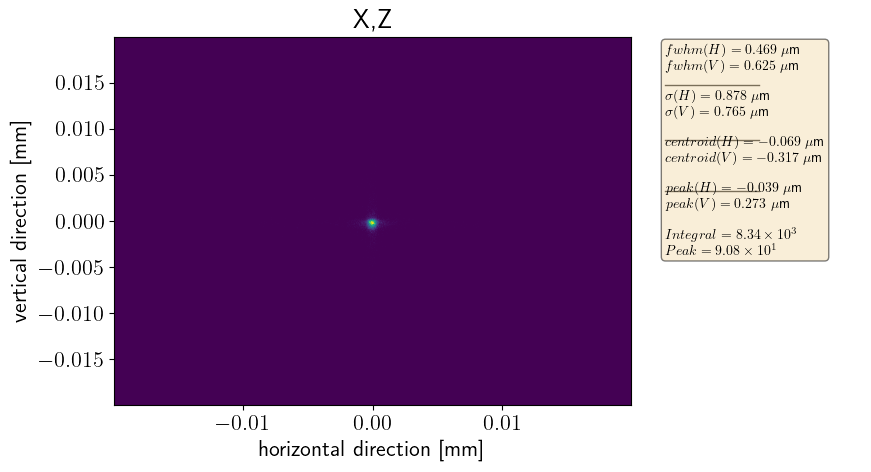

In [16]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [17]:
dw.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.0008785653626669424,
  'h_fwhm': 0.0005371093750000458,
  'h_centroid': -6.853201422490091e-05,
  'h_peak': -7.324218750000104e-05,
  'v_sigma': 0.000764341520108446,
  'v_fwhm': 0.0006835937500000583,
  'v_centroid': -0.0003168719734466379,
  'v_peak': 0.00021972656249999965,
  'integral_intensity': 8337.701904141451,
  'peak_intensity': 46.08654799951838,
  'gaussian_fit': {}}}

In [18]:
save_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi')

In [19]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/focused_beam.joblib']

In [20]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID


In [20]:
m2 = apu.CMAP

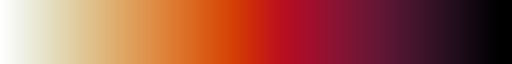

In [21]:
m2

In [22]:
maxcount = hist.data_2D.max()

In [23]:
maxcount

46.08654799951838

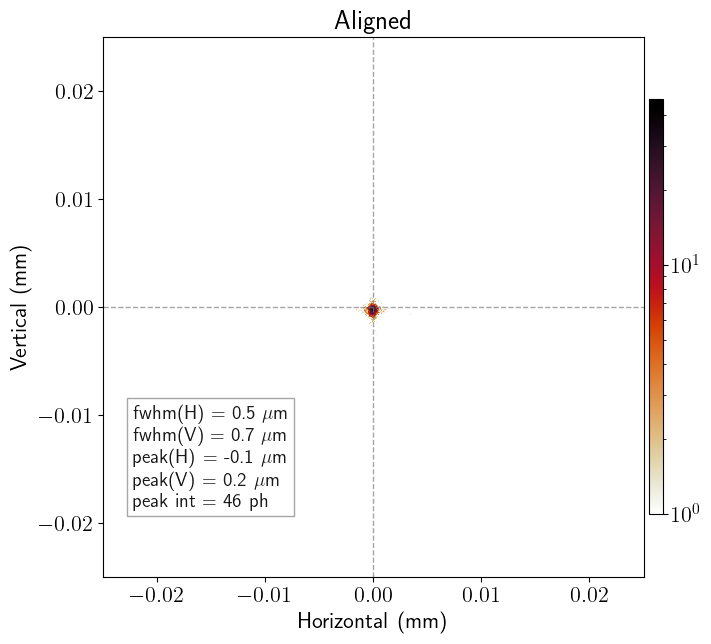

In [24]:
dwd = dw._DictionaryWrapper__dictionary

plt.figure(figsize=[7,7], constrained_layout=True)


plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(1, maxcount))
#plt.xlim(-0.025,0.025)
#plt.ylim(-0.025,0.025)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Aligned")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

(-0.02, 0.02)

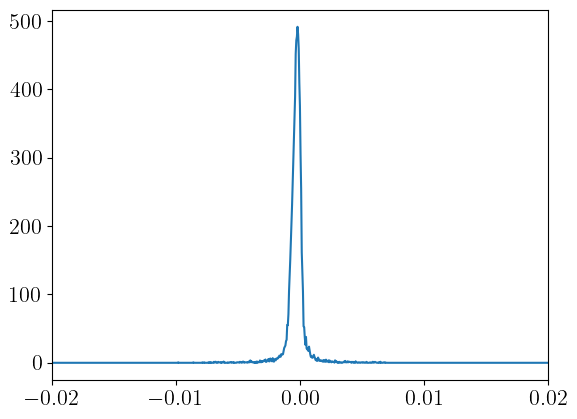

In [25]:
plt.plot(hist.hh, hist.data_2D.sum(axis=0))
plt.xlim([-0.02,0.02])

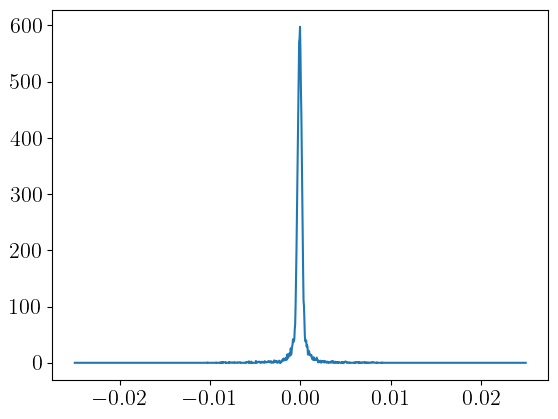

In [26]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [27]:
(hist.data_2D.sum(axis=1).max() + hist.data_2D.sum(axis=0).max()) / 2

544.4880272247146

In [28]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 8.694e-04
Focused beam system peak_distance: 2.316e-04


In [29]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_trans': 0.0, 'vb_trans': 0.0, 'hb_pitch': 3.0000000000000506, 'vb_pitch': 3.0000000000000506, 'hb_1': 215.5, 'hb_2': 112.50000000000001, 'vb_1': 143.99999999999997, 'vb_2': 231.5}


In [30]:
random_move_ranges = {k: np.array(v) * 0.5 for k,v in opt_params.move_motors_ranges.items()}
random_move_ranges

{'hb_trans': array([-10.,  10.]),
 'vb_trans': array([-10.,  10.]),
 'hb_pitch': array([-0.01,  0.01]),
 'vb_pitch': array([-0.01,  0.01]),
 'hb_1': array([-15.,  15.]),
 'hb_2': array([-15.,  15.]),
 'vb_1': array([-15.,  15.]),
 'vb_2': array([-15.,  15.])}

In [31]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=random_move_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [9.089436379296334, -5.806764266856732, 3.006981317008028, 2.9930186829920733, 215.88410000000002, 101.5776, 149.6711, 241.75239999999994]
Random initialization is (RELATIVE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [9.

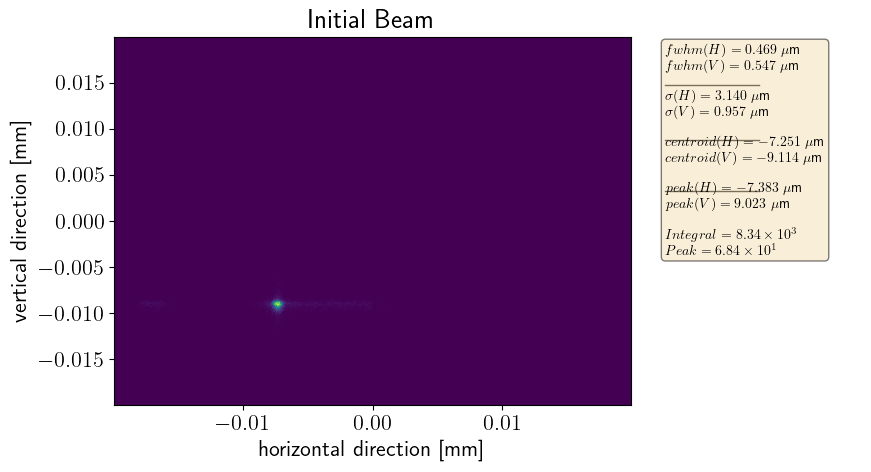

Perturbed beam system fwhm: 7.949e-04
Perturbed beam system peak_distance: 1.177e-02


In [32]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [33]:
hist_pert.data_2D.max()

31.521158973653204

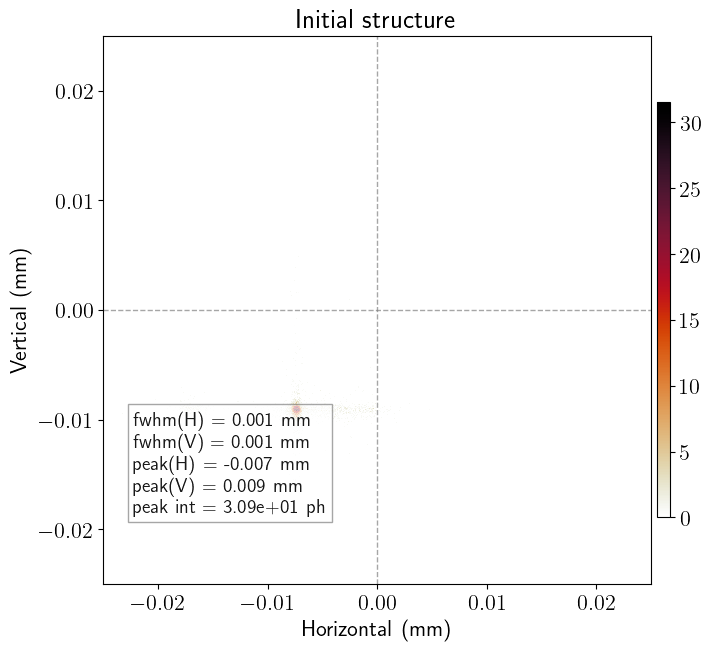

In [34]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
#plt.xlim(-0.05,0.05)
#plt.ylim(-0.05,0.05)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

In [35]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [36]:
perturbed_positions

array([  9.12003419,  -5.8463638 ,   3.0065689 ,   2.99298564,
       215.88413849, 101.57758812, 149.67109439, 241.75243173])

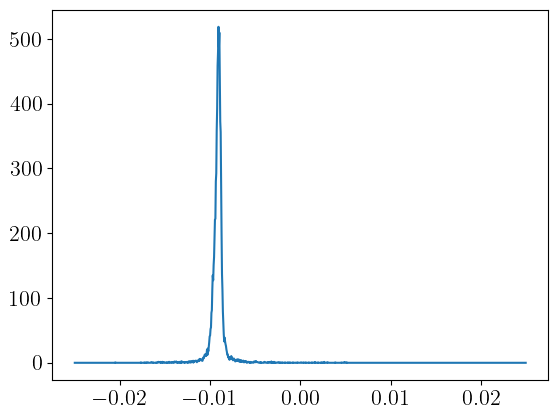

In [37]:
plt.plot(hist_pert.hh, hist_pert.data_2D.sum(axis=0))
#plt.xlim([-0.02,0.02])

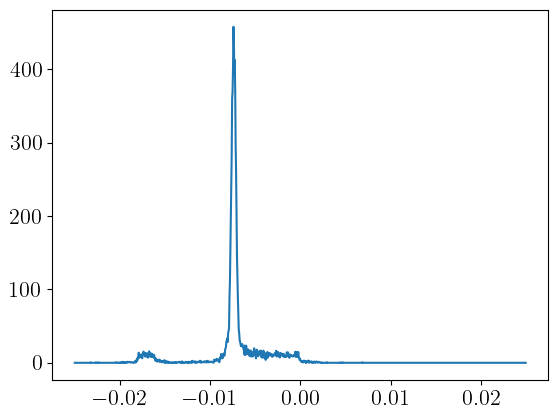

In [38]:
plt.plot(hist_pert.vv, hist_pert.data_2D.sum(axis=1))

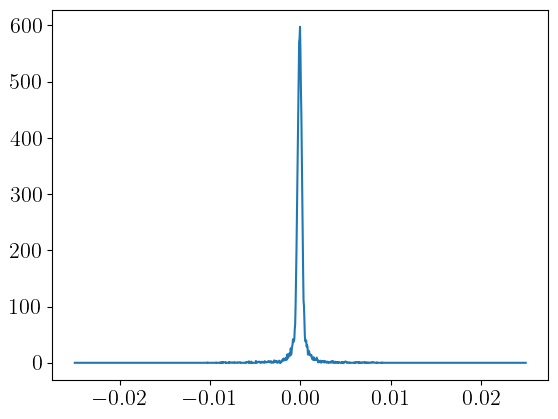

In [39]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [40]:
hist.data_2D.sum()

8337.701904141453

#### Calculating without removing noise : two step optimization

In [41]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

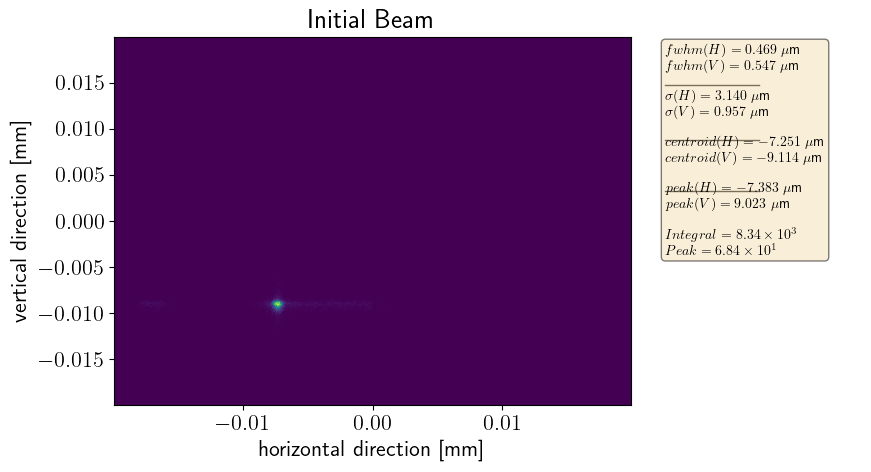

In [42]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [43]:
hist_pert.data_2D.max()

31.521158973652856

In [44]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 7.949e-04
Perturbed beam system peak_distance: 1.177e-02


In [45]:
opt_params = OptimizationParameters()

In [48]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [49]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [50]:
attribs_init

{'fwhm': 0.0007948642869189987, 'peak_distance': 0.01177036363232808}

In [51]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-07-04 17:26:38,503] A new study created in memory with name: no-name-f639c47e-a01d-4b9a-9e80-15e3b6eb8087


In [52]:
opt_trial.trials(50, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline34IDC/optimization/optuna_botorch.py:316: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

Pruning trial with parameters [10.8, -19.2, 0.0045000000000000005, 0.009750000000000002, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:27:06,723] Trial 2 pruned. 


Pruning trial with parameters [-0.09999999999999787, -11.1, -0.013000000000000001, 0.009750000000000002, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:27:16,341] Trial 3 pruned. 


Pruning trial with parameters [-13.3, -16.5, 0.006249999999999999, 0.016749999999999998, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:27:25,754] Trial 4 finished with values: [0.0011357132177357422, 0.016878612272972937] and parameters: {'hb_trans': -19.9, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.0115, 'vb_pitch': 0.0045000000000000005, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:27:35,218] Trial 5 pruned. 


Pruning trial with parameters [8.8, -8.399999999999999, 0.016749999999999998, 0.008, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:27:42,973] Trial 6 finished with values: [0.013046250014270134, 0.02311404510004341] and parameters: {'hb_trans': 1.7000000000000028, 'vb_trans': -14.399999999999999, 'hb_pitch': -0.006, 'vb_pitch': 0.006249999999999999, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:27:51,595] Trial 7 finished with values: [0.0007595873626028013, 0.012293686566094645] and parameters: {'hb_trans': -2.3999999999999986, 'vb_trans': -2.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0007500000000000007, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:28:00,926] Trial 8 pruned. 


Pruning trial with parameters [6.0, 4.0, 0.0115, -0.0007500000000000007, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:28:10,026] Trial 9 pruned. 


Pruning trial with parameters [16.300000000000004, -7.299999999999999, -0.0165, -0.0095, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:28:18,276] Trial 10 finished with values: [0.0010449675077653575, 0.007554091263352826] and parameters: {'hb_trans': -15.5, 'vb_trans': 13.100000000000001, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:28:26,159] Trial 11 finished with values: [0.0010563138502336807, 0.015889372619669544] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:28:34,308] Trial 12 finished with values: [0.0008693600495491393, 0.00892667068958073] and parameters: {'hb_trans': -6.0, 'vb_trans': 10.100000000000001, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:28:44,180] Trial 13 pruned. 


Pruning trial with parameters [-7.0, -13.399999999999999, -0.00425, -0.0165, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:28:52,507] Trial 14 pruned. 


Pruning trial with parameters [12.800000000000004, -14.0, -0.006, 0.016749999999999998, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:29:03,021] Trial 15 pruned. 


Pruning trial with parameters [19.5, -1.8000000000000007, 0.013250000000000001, -0.01125, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 17:29:11,006] Trial 16 finished with values: [0.0012010130738525284, 0.024308487548792293] and parameters: {'hb_trans': 3.8000000000000007, 'vb_trans': 16.1, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:29:20,106] Trial 17 finished with values: [0.023346023060796025, 0.019250701148404964] and parameters: {'hb_trans': -18.5, 'vb_trans': -5.799999999999999, 'hb_pitch': -0.01825, 'vb_pitch': -0.00775, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 17:29:28,980] Trial 18 finished with values: [0.0010563138502336807, 0.005154201216133456] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 10.900000000000002, 'hb_pitch': -0.02, 'vb_pitch': -0.00425, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWa

Pruning trial with parameters [-13.0, 19.1, -0.01825, -0.01825, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 17:33:05,877] Trial 35 finished with values: [0.0007

Pruning trial with parameters [18.0, -8.6, 0.016749999999999998, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 17:36:09,327] Trial 48 finished with values: [0.0008315130061488209, 0.005625309405824259] and parameters: {'hb_trans': 1.2000000000000028, 'vb_trans': 2.5, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0185, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

In [65]:
opt_trial.trials(75)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:54:21,209] Trial 50 finished with values: [0.0009328600182883022, 0.0026450696028148947] and parameters: {'hb_trans': -9.2, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.006, 'vb_pitch': 0.008, 'hb_1': 1.865000000000002, 'hb_2': -8.232299999999999, 'vb_1': -17.1424, 'vb_2': 0.3387000000000029}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:54:35,323] Trial 51 finished with values: [0.001139904055657202, 0.005204835352863243] and parameters: {'hb_trans': -7.5, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.006249999999999999, 'hb_1': 12.780000000000001, 'hb_2': -0.12289999999999779, 'vb_1': -19.5206, 'vb_2': 0.9771999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:54:48,988] Trial 52 finished with values: [0.00164138049941143, 0.002762351647445616] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': -1.5999999999999979, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -15.0894, 'hb_2': -0.6560999999999986, 'vb_1': -14.589699999999999, 'vb_2': -5.373199999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:55:03,765] Trial 53 finished with values: [0.002039122365021766, 0.006374361642030029] and parameters: {'hb_trans': -5.0, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -20.650199999999998, 'hb_2': -4.266399999999997, 'vb_1': -23.906399999999998, 'vb_2': 0.21649999999999991}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:55:17,260] Trial 54 finished with values: [0.0012900239075804719, 0.0045314236311695755] and parameters: {'hb_trans': -5.1, 'vb_trans': 5.0, 'hb_pitch': -0.00775, 'vb_pitch': 0.0115, 'hb_1': -16.330199999999998, 'hb_2': 8.454999999999998, 'vb_1': -20.423000000000002, 'vb_2': 7.3075000000000045}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:55:29,680] Trial 55 finished with values: [0.0009003461384075852, 0.005253620352641822] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 10.600000000000001, 'hb_pitch': -0.01125, 'vb_pitch': 0.0045000000000000005, 'hb_1': 4.156100000000002, 'hb_2': 11.026299999999999, 'vb_1': -25.7072, 'vb_2': -2.315299999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:55:43,425] Trial 56 finished with values: [0.0009082556268427666, 0.00228946117275394] and parameters: {'hb_trans': -8.0, 'vb_trans': 9.3, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.006, 'hb_1': -11.372699999999998, 'hb_2': 8.516300000000001, 'vb_1': -11.1832, 'vb_2': 6.322600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:55:58,096] Trial 57 finished with values: [0.0010018693617521942, 0.0022282430095907496] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 8.400000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 4.676700000000004, 'hb_2': 14.8906, 'vb_1': -12.9662, 'vb_2': -6.5366}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:56:12,767] Trial 58 finished with values: [0.0009379576519677824, 0.0019813030825462387] and parameters: {'hb_trans': -9.1, 'vb_trans': 10.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': -19.066899999999997, 'hb_2': 11.8478, 'vb_1': -7.677199999999999, 'vb_2': -17.2397}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:56:25,230] Trial 59 finished with values: [0.0013566839833448231, 0.00014235722399524712] and parameters: {'hb_trans': -9.5, 'vb_trans': 8.900000000000002, 'hb_pitch': -0.0095, 'vb_pitch': -0.0007500000000000007, 'hb_1': -17.5571, 'hb_2': 1.8616000000000028, 'vb_1': -11.926199999999998, 'vb_2': -12.529999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:56:42,162] Trial 60 finished with values: [0.0028345557175197713, 0.003735431346165922] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': 6.300000000000001, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.00425, 'hb_1': -1.3101999999999983, 'hb_2': 12.738, 'vb_1': -25.8456, 'vb_2': -22.9175}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:56:55,937] Trial 61 finished with values: [0.0012816801512116997, 0.002353140773441698] and parameters: {'hb_trans': -6.6, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.006249999999999999, 'hb_1': -19.5078, 'hb_2': 15.098200000000006, 'vb_1': 8.398499999999999, 'vb_2': -8.777099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:57:11,429] Trial 62 finished with values: [0.0020037387235043885, 0.003592270256240762] and parameters: {'hb_trans': -3.0, 'vb_trans': 4.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.0185, 'hb_1': -19.6547, 'hb_2': 9.297899999999998, 'vb_1': 16.528, 'vb_2': -14.5925}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:57:25,831] Trial 63 finished with values: [0.0008008407942801818, 0.0020265142548288226] and parameters: {'hb_trans': -7.5, 'vb_trans': 5.700000000000003, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': -27.8024, 'hb_2': 9.376400000000004, 'vb_1': -27.6524, 'vb_2': -1.5412}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:57:39,805] Trial 64 finished with values: [0.0013327484437458345, 0.003068217331908741] and parameters: {'hb_trans': -9.5, 'vb_trans': 6.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.0024999999999999988, 'hb_1': -29.9814, 'hb_2': -1.7715999999999994, 'vb_1': 3.564799999999998, 'vb_2': -3.462799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:57:55,490] Trial 65 finished with values: [0.002665496887491669, 0.004254636367339297] and parameters: {'hb_trans': -2.8000000000000007, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.015000000000000003, 'hb_1': -23.225, 'hb_2': 19.314500000000002, 'vb_1': 8.3979, 'vb_2': 14.896}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:58:12,118] Trial 66 finished with values: [0.0027295751678466556, 0.006168694944435563] and parameters: {'hb_trans': -1.1999999999999993, 'vb_trans': 3.6000000000000014, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -27.3301, 'hb_2': -9.037199999999999, 'vb_1': -6.3977, 'vb_2': -0.3722999999999992}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:58:27,941] Trial 67 finished with values: [0.0017914000320161823, 0.0032493640570906627] and parameters: {'hb_trans': -2.599999999999998, 'vb_trans': 2.5, 'hb_pitch': 0.008, 'vb_pitch': 0.016749999999999998, 'hb_1': 16.923700000000004, 'hb_2': 18.070800000000006, 'vb_1': -12.2542, 'vb_2': 14.694400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:58:43,832] Trial 68 finished with values: [0.0011241078548068673, 0.0029831147254113133] and parameters: {'hb_trans': -6.5, 'vb_trans': 9.700000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -9.790299999999998, 'hb_2': 2.594999999999999, 'vb_1': -11.7426, 'vb_2': -6.849799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:58:58,488] Trial 69 finished with values: [0.000988694176333902, 0.0006668213029173665] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': 4.200000000000003, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.008, 'hb_1': 0.3439000000000014, 'hb_2': 17.386400000000002, 'vb_1': -14.2654, 'vb_2': -14.7182}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:59:12,595] Trial 70 finished with values: [0.0014058769578993355, 0.0023753264353428304] and parameters: {'hb_trans': -3.5, 'vb_trans': 6.400000000000002, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.006249999999999999, 'hb_1': -21.966099999999997, 'hb_2': 15.589400000000005, 'vb_1': -8.523299999999999, 'vb_2': 3.1122000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:59:27,561] Trial 71 finished with values: [0.0029877067462460273, 0.0038541756019832376] and parameters: {'hb_trans': -7.799999999999999, 'vb_trans': 4.0, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.016749999999999998, 'hb_1': 6.4589, 'hb_2': 4.310400000000001, 'vb_1': -25.4985, 'vb_2': -24.467}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:59:40,293] Trial 72 finished with values: [0.0012448778109358447, 0.0013233232649284804] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.6715000000000018, 'hb_2': 23.184800000000003, 'vb_1': -4.3028999999999975, 'vb_2': 7.745899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 17:59:54,603] Trial 73 finished with values: [0.0015254393898256485, 0.0014862530522680105] and parameters: {'hb_trans': -10.1, 'vb_trans': 11.3, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -17.5106, 'hb_2': 29.093500000000006, 'vb_1': -0.8218999999999994, 'vb_2': 5.705200000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:00:09,859] Trial 74 finished with values: [0.0012448778109358447, 0.003894176899391563] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': -2.3000000000000007, 'hb_pitch': 0.0185, 'vb_pitch': 0.016749999999999998, 'hb_1': 11.8414, 'hb_2': 12.189700000000002, 'vb_1': -10.572699999999998, 'vb_2': -24.658}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:00:23,970] Trial 75 finished with values: [0.0008315130061488209, 0.004516667545970724] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 4.5, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -5.4114, 'hb_2': 29.7395, 'vb_1': -11.538799999999998, 'vb_2': -4.266099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:00:39,504] Trial 76 finished with values: [0.00164138049941143, 0.005267217287824124] and parameters: {'hb_trans': -10.0, 'vb_trans': 6.5, 'hb_pitch': 0.008, 'vb_pitch': 0.009750000000000002, 'hb_1': -7.299799999999998, 'hb_2': 21.131800000000005, 'vb_1': -17.963, 'vb_2': -13.032}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:00:54,646] Trial 77 finished with values: [0.0011241078548068673, 0.004081896912038898] and parameters: {'hb_trans': -2.6999999999999993, 'vb_trans': 1.1000000000000014, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.008, 'hb_1': 4.144300000000001, 'hb_2': 8.035600000000002, 'vb_1': -1.8395999999999972, 'vb_2': -13.5806}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:01:10,477] Trial 78 finished with values: [0.002069298837931533, 0.001798373716865517] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0115, 'vb_pitch': 0.013250000000000001, 'hb_1': 27.2982, 'hb_2': 22.923500000000004, 'vb_1': 20.1612, 'vb_2': -5.052699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:01:26,421] Trial 79 finished with values: [0.001717334511237351, 0.0015704904332104887] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': 10.900000000000002, 'hb_pitch': -0.02, 'vb_pitch': -0.00425, 'hb_1': -14.398299999999999, 'hb_2': -10.233999999999998, 'vb_1': -13.1293, 'vb_2': 0.35970000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:01:43,915] Trial 80 finished with values: [0.003384320986555651, 0.0023692964029319516] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 6.900000000000002, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': 25.3296, 'hb_2': 28.2436, 'vb_1': -24.3572, 'vb_2': -16.3738}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:02:00,875] Trial 81 finished with values: [0.0013566839833448231, 0.0023863419205639464] and parameters: {'hb_trans': -6.699999999999999, 'vb_trans': 2.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.009750000000000002, 'hb_1': 21.344, 'hb_2': 14.998400000000004, 'vb_1': -29.1881, 'vb_2': -3.0595999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:02:15,247] Trial 82 finished with values: [0.0011799849583589454, 0.0022706390671067226] and parameters: {'hb_trans': -4.1, 'vb_trans': 2.900000000000002, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.008, 'hb_1': 11.784800000000004, 'hb_2': 9.7468, 'vb_1': 0.6960000000000015, 'vb_2': 0.5139000000000031}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:02:31,122] Trial 83 finished with values: [0.0008008407942801818, 0.003957940466943403] and parameters: {'hb_trans': -8.7, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.00425, 'vb_pitch': -0.0007500000000000007, 'hb_1': 6.4632000000000005, 'hb_2': 10.747100000000003, 'vb_1': -4.997799999999998, 'vb_2': -2.2982999999999976}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:02:48,887] Trial 84 finished with values: [0.0008638577154763496, 0.002740689207953855] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': -8.2564, 'hb_2': 12.846200000000003, 'vb_1': -9.404799999999998, 'vb_2': -13.2695}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:03:04,872] Trial 85 finished with values: [0.001205965726096633, 0.0015336229272011146] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': 9.3, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -28.9374, 'hb_2': 17.307700000000004, 'vb_1': 5.530200000000001, 'vb_2': 4.7402000000000015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:03:20,982] Trial 86 finished with values: [0.0010300304252798234, 0.001328717267987088] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 8.600000000000001, 'hb_pitch': 0.008, 'vb_pitch': -0.0007500000000000007, 'hb_1': -14.8567, 'hb_2': 25.9082, 'vb_1': -10.323899999999998, 'vb_2': -4.077499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:03:39,287] Trial 87 finished with values: [0.0008315130061488209, 0.0028263429538535924] and parameters: {'hb_trans': -13.5, 'vb_trans': 10.700000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.006, 'hb_1': 3.549900000000001, 'hb_2': 10.670300000000005, 'vb_1': -7.7913, 'vb_2': -27.3256}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:03:57,136] Trial 88 finished with values: [0.0012900239075804719, 0.001779716500840586] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 8.3, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': -9.264299999999999, 'hb_2': -1.2180999999999997, 'vb_1': -6.312799999999999, 'vb_2': 3.4618000000000038}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:04:15,361] Trial 89 finished with values: [0.0009480706952611941, 0.0026594524152629335] and parameters: {'hb_trans': -7.0, 'vb_trans': 5.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.5778999999999996, 'hb_2': 19.3714, 'vb_1': -23.7432, 'vb_2': -2.2271}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:04:38,351] Trial 90 finished with values: [0.0015191747252056027, 0.00036046931299397994] and parameters: {'hb_trans': -7.0, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0010000000000000009, 'hb_1': 13.607500000000002, 'hb_2': 11.018700000000003, 'vb_1': -24.4396, 'vb_2': 13.158900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:04:55,671] Trial 91 finished with values: [0.0021221986144631427, 0.0022716888309478756] and parameters: {'hb_trans': -4.399999999999999, 'vb_trans': 2.1000000000000014, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.016749999999999998, 'hb_1': 10.211200000000005, 'hb_2': 4.066700000000004, 'vb_1': 29.245800000000003, 'vb_2': -20.575499999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:05:12,717] Trial 92 finished with values: [0.0016164985700437755, 0.003936195036188506] and parameters: {'hb_trans': -11.6, 'vb_trans': 10.600000000000001, 'hb_pitch': -0.00775, 'vb_pitch': -0.0095, 'hb_1': -20.2002, 'hb_2': 18.6802, 'vb_1': 8.7896, 'vb_2': -17.6039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:05:28,586] Trial 93 finished with values: [0.0012900239075804719, 0.0017823937742621077] and parameters: {'hb_trans': -10.0, 'vb_trans': 8.200000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.0007500000000000007, 'hb_1': -8.0857, 'hb_2': 20.803000000000004, 'vb_1': 1.4491000000000014, 'vb_2': -14.632399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:05:47,254] Trial 94 finished with values: [0.003134522235489336, 0.0038256142615466886] and parameters: {'hb_trans': -8.1, 'vb_trans': 9.400000000000002, 'hb_pitch': -0.01825, 'vb_pitch': -0.0007500000000000007, 'hb_1': 21.968400000000003, 'hb_2': 15.760100000000001, 'vb_1': -27.9776, 'vb_2': -23.617}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:06:05,666] Trial 95 finished with values: [0.0012323661586059608, 0.0029176592273295536] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 8.100000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.00425, 'hb_1': -28.4747, 'hb_2': 27.729400000000005, 'vb_1': -11.720599999999997, 'vb_2': -14.165899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:06:27,986] Trial 96 finished with values: [0.0009765625000000833, 0.0028839611876649808] and parameters: {'hb_trans': -4.699999999999999, 'vb_trans': 2.8000000000000007, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.006249999999999999, 'hb_1': -3.4406, 'hb_2': 25.292, 'vb_1': 1.1522000000000006, 'vb_2': 5.122}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:06:47,412] Trial 97 finished with values: [0.0014850494458737153, 0.002520448975909082] and parameters: {'hb_trans': -12.5, 'vb_trans': 10.5, 'hb_pitch': -0.01475, 'vb_pitch': -0.0007500000000000007, 'hb_1': 15.6284, 'hb_2': 11.051900000000003, 'vb_1': -25.6142, 'vb_2': 18.7868}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:07:03,973] Trial 98 finished with values: [0.0007948642869189987, 0.0014054529262328371] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': 5.5, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.2997999999999976, 'hb_2': 29.454, 'vb_1': -7.561999999999998, 'vb_2': -23.7387}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:07:23,314] Trial 99 finished with values: [0.0011523851290241164, 0.000865925188035558] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 6.200000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.002749999999999999, 'hb_1': 8.125300000000003, 'hb_2': -18.272100000000002, 'vb_1': -24.301299999999998, 'vb_2': 7.036900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:07:46,293] Trial 100 finished with values: [0.0016701788453602079, 0.0032228411997117655] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': -1.5, 'hb_pitch': 0.008, 'vb_pitch': 0.0185, 'hb_1': -14.0984, 'hb_2': 13.8491, 'vb_1': 26.841300000000004, 'vb_2': -13.0745}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:08:02,533] Trial 101 finished with values: [0.0017263349150063668, 0.0020370751997073385] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 5.300000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0115, 'hb_1': 9.084299999999999, 'hb_2': 20.3046, 'vb_1': 2.791499999999999, 'vb_2': -19.0844}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:08:18,731] Trial 102 finished with values: [0.0010054326309558476, 0.0009193442570196634] and parameters: {'hb_trans': -7.1, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0115, 'hb_1': 2.439399999999999, 'hb_2': 26.640900000000002, 'vb_1': -12.093399999999999, 'vb_2': 3.9883000000000024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:08:33,237] Trial 103 finished with values: [0.00103580094900382, 0.0018377157486873844] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 9.0, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': 19.693800000000003, 'hb_2': 2.5075000000000003, 'vb_1': -15.8881, 'vb_2': -24.9207}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:08:52,867] Trial 104 finished with values: [0.0020449601163450887, 0.0020382452602286908] and parameters: {'hb_trans': -12.1, 'vb_trans': 9.700000000000003, 'hb_pitch': -0.01825, 'vb_pitch': -0.006, 'hb_1': -16.5874, 'hb_2': -6.9263999999999974, 'vb_1': -18.098300000000002, 'vb_2': -25.7375}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:09:10,853] Trial 105 finished with values: [0.0007627196949128243, 0.0001244877810935739] and parameters: {'hb_trans': -2.8000000000000007, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.0619999999999976, 'hb_2': 9.326300000000003, 'vb_1': -5.336599999999997, 'vb_2': -4.588999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:09:29,581] Trial 106 finished with values: [0.0012246031449204612, 0.001693216883242159] and parameters: {'hb_trans': -6.299999999999999, 'vb_trans': 7.5, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 20.037200000000006, 'hb_2': -9.6679, 'vb_1': -11.2515, 'vb_2': -0.5300999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:09:49,582] Trial 107 finished with values: [0.0010300304252798234, 0.0030821726564716923] and parameters: {'hb_trans': -8.7, 'vb_trans': 2.400000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0185, 'hb_1': 16.1822, 'hb_2': 8.2074, 'vb_1': -18.176000000000002, 'vb_2': 1.4548000000000023}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:10:08,634] Trial 108 finished with values: [0.0012448778109358447, 0.0006108396485935939] and parameters: {'hb_trans': -10.7, 'vb_trans': 11.200000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.00425, 'hb_1': -22.0717, 'hb_2': 3.1345000000000027, 'vb_1': -9.892699999999998, 'vb_2': 18.323300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:10:29,417] Trial 109 finished with values: [0.0024281868670229328, 0.0018876349394607124] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 13.0, 'hb_pitch': -0.006, 'vb_pitch': -0.006, 'hb_1': 0.6108000000000011, 'hb_2': 2.434899999999999, 'vb_1': -24.4262, 'vb_2': -16.386400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:10:47,188] Trial 110 finished with values: [0.0012010130738525284, 0.002624256210309624] and parameters: {'hb_trans': -8.6, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.006249999999999999, 'hb_1': -7.982899999999997, 'hb_2': 11.575099999999999, 'vb_1': -22.0826, 'vb_2': 15.991600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:11:06,981] Trial 111 finished with values: [0.0012323661586059608, 0.0022121350175926353] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 8.3, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': 3.3537999999999997, 'hb_2': -18.6017, 'vb_1': -2.5710999999999977, 'vb_2': 27.614800000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:11:25,526] Trial 112 finished with values: [0.0008008407942801818, 0.0020276904094576297] and parameters: {'hb_trans': -4.6, 'vb_trans': 6.700000000000003, 'hb_pitch': 0.0185, 'vb_pitch': 0.0045000000000000005, 'hb_1': 1.0694000000000017, 'hb_2': 24.844900000000003, 'vb_1': -8.728299999999997, 'vb_2': 5.108800000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:11:44,883] Trial 113 finished with values: [0.0012477472987482154, 0.0019485419862534104] and parameters: {'hb_trans': -4.1, 'vb_trans': 2.400000000000002, 'hb_pitch': 0.0185, 'vb_pitch': 0.009750000000000002, 'hb_1': 5.809400000000004, 'hb_2': -1.629299999999997, 'vb_1': -26.2236, 'vb_2': 13.300699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:12:05,206] Trial 114 finished with values: [0.0007627196949128243, 0.004910201504179387] and parameters: {'hb_trans': -2.0, 'vb_trans': 7.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.013250000000000001, 'hb_1': 0.35320000000000107, 'hb_2': -14.8201, 'vb_1': 16.92, 'vb_2': 1.8636000000000017}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:12:26,151] Trial 115 finished with values: [0.0013147375017419343, 0.00032572422031558555] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': 9.900000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -10.7085, 'hb_2': -6.93, 'vb_1': -6.770199999999999, 'vb_2': 17.4471}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:12:48,502] Trial 116 finished with values: [0.0010018693617521942, 0.002535538795892036] and parameters: {'hb_trans': -0.5999999999999979, 'vb_trans': 3.6000000000000014, 'hb_pitch': 0.0185, 'vb_pitch': 0.008, 'hb_1': 3.406100000000002, 'hb_2': 27.809000000000005, 'vb_1': -1.6437999999999988, 'vb_2': -6.785899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:13:10,781] Trial 117 finished with values: [0.0014850494458737153, 0.0010836104014244213] and parameters: {'hb_trans': -3.5, 'vb_trans': 10.700000000000003, 'hb_pitch': 0.0185, 'vb_pitch': -0.0007500000000000007, 'hb_1': -25.3765, 'hb_2': 24.302400000000006, 'vb_1': 28.689300000000003, 'vb_2': -13.6419}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:13:32,957] Trial 118 finished with values: [0.0013758791800397043, 0.0008957000160080148] and parameters: {'hb_trans': -3.5, 'vb_trans': 7.400000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.002749999999999999, 'hb_1': 14.469900000000003, 'hb_2': -28.7662, 'vb_1': -13.349799999999998, 'vb_2': 10.452800000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:13:53,622] Trial 119 finished with values: [0.002018557285995718, 0.0009549612898246078] and parameters: {'hb_trans': -2.6999999999999993, 'vb_trans': 8.900000000000002, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.0024999999999999988, 'hb_1': -22.0884, 'hb_2': 6.608899999999998, 'vb_1': -29.6606, 'vb_2': 14.070300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:14:11,011] Trial 120 finished with values: [0.0019186408891006031, 0.003495391263658416] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 12.5, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -21.0801, 'hb_2': -7.588699999999999, 'vb_1': -11.357299999999999, 'vb_2': -27.3415}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:14:30,618] Trial 121 finished with values: [0.0007595873626028013, 0.002271688830947874] and parameters: {'hb_trans': -3.8999999999999986, 'vb_trans': 4.800000000000001, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.013250000000000001, 'hb_1': -2.4771, 'hb_2': 4.146500000000003, 'vb_1': -7.8592999999999975, 'vb_2': -5.439699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:14:50,878] Trial 122 finished with values: [0.0025353037081539604, 0.0030752029103887565] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 6.5, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': -27.4026, 'hb_2': -8.7212, 'vb_1': -17.8119, 'vb_2': 8.938300000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:15:13,099] Trial 123 finished with values: [0.0017605230837228012, 0.0013070076967113449] and parameters: {'hb_trans': -4.6, 'vb_trans': 12.200000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.006, 'hb_1': 12.762900000000002, 'hb_2': 3.3735, 'vb_1': -29.1867, 'vb_2': 20.057500000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:15:40,070] Trial 124 finished with values: [0.002085938414384341, 0.001741802634935251] and parameters: {'hb_trans': -3.3999999999999986, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.00425, 'hb_1': 8.182000000000002, 'hb_2': -3.5056999999999974, 'vb_1': 4.259, 'vb_2': 12.359500000000004}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_36263/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

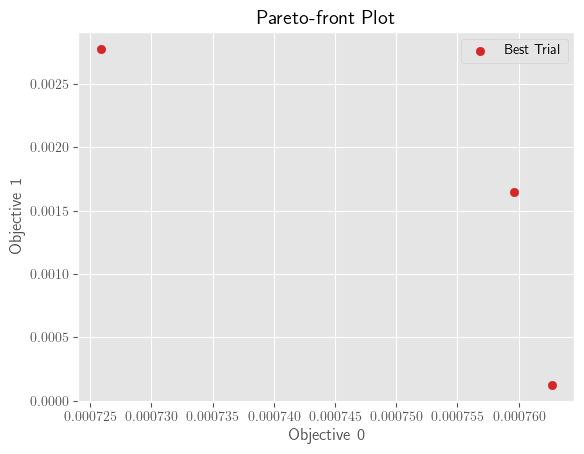

In [66]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [67]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/trials.joblib']

#### This is the analysis part

In [68]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [69]:
trials_file = save_dir / "trials.joblib"

In [70]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-07-04 18:16:24,341] A new study created in memory with name: no-name-c45dce2e-000a-4e97-b21b-66cc19b45bbe


Assuming minimization for all objectives.


In [71]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [72]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 44
Trial values: peak_distance 2.777e-03 fwhm 7.259e-04
Trial dw:
{'h_sigma': 0.0010166893437359005, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0004004375790049321, 'h_peak': 0.00031738281250000104, 'v_sigma': 0.001100183093628245, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -0.002781365451110083, 'v_peak': 0.002758789062500001, 'integral_intensity': 8338.26310545328, 'peak_intensity': 43.308447726200214, 'gaussian_fit': {}}
Actual fwhm 0.0007258822630527232


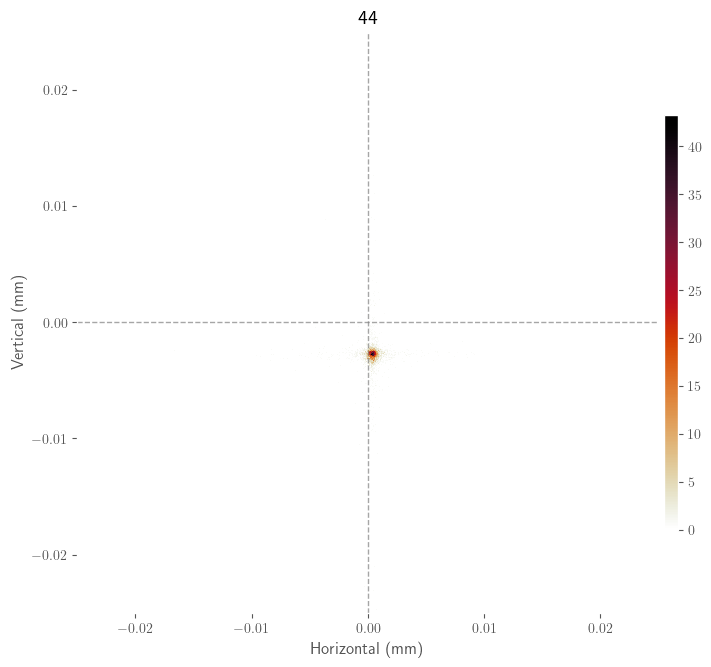

Trial number 46
Trial values: peak_distance 1.650e-03 fwhm 7.596e-04
Trial dw:
{'h_sigma': 0.001061866121083209, 'h_fwhm': 0.0005371093750000458, 'h_centroid': -0.0014407604221311847, 'h_peak': -0.0014404296874999997, 'v_sigma': 0.0009096724975991424, 'v_fwhm': 0.0005371093750000458, 'v_centroid': 0.0006514183005948794, 'v_peak': -0.000805664062500001, 'integral_intensity': 8340.760527281469, 'peak_intensity': 42.764349668379374, 'gaussian_fit': {}}
Actual fwhm 0.0007595873626028013


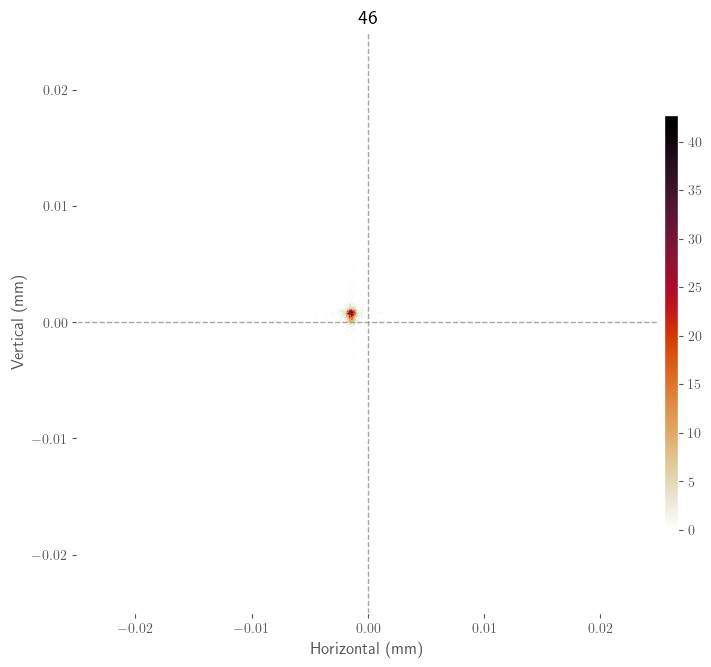

Trial number 105
Trial values: peak_distance 1.245e-04 fwhm 7.627e-04
Trial dw:
{'h_sigma': 0.0011763629219399825, 'h_fwhm': 0.00058593750000005, 'h_centroid': 8.883766404653806e-05, 'h_peak': 0.0001220703125, 'v_sigma': 0.0007385077540939687, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -1.3030733739282036e-05, 'v_peak': -2.4414062500000347e-05, 'integral_intensity': 8342.788241831293, 'peak_intensity': 45.48565582398579, 'gaussian_fit': {}}
Actual fwhm 0.0007627196949128243


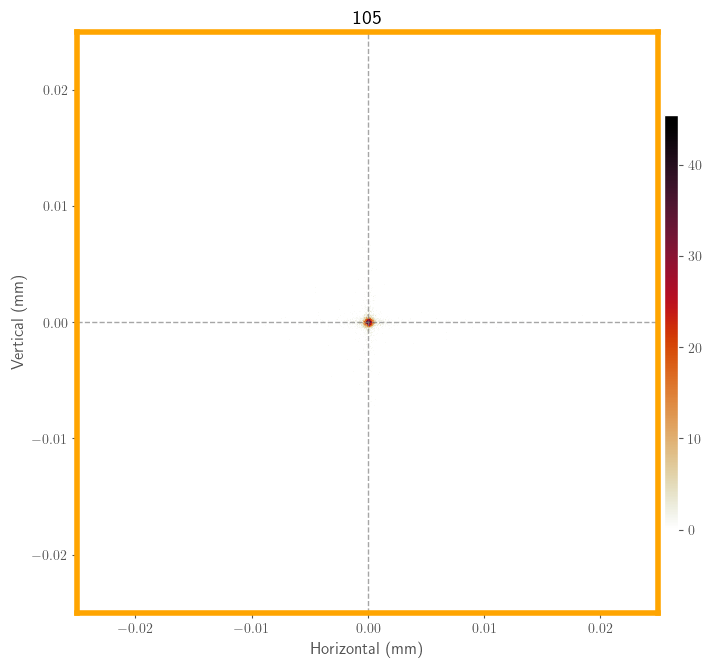

In [73]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

### One step optimization

In [79]:

save_dir = cur_dir / 'nf_fwhm_pl_one_step'
save_dir.mkdir(exist_ok=True)

In [80]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


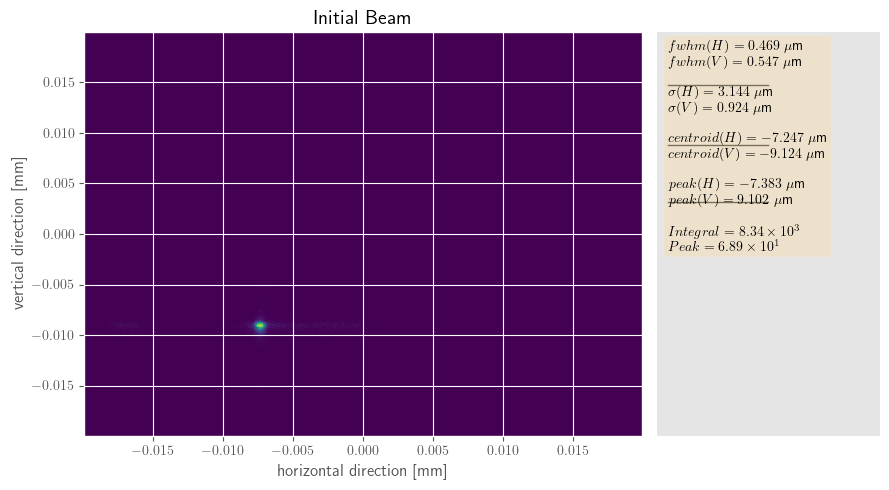

In [81]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [82]:
hist_pert.data_2D.max()

33.627622207106214

In [83]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 7.596e-04
Perturbed beam system peak_distance: 1.173e-02


In [84]:
opt_params = OptimizationParameters()

In [85]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [86]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [87]:
attribs_init

{'fwhm': 0.0007595873626028013, 'peak_distance': 0.011732424069704931}

In [88]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-07-04 18:20:07,301] A new study created in memory with name: no-name-b098968a-99ce-4fd0-8880-f6a6a6f5f6e3


In [89]:
opt_trial.trials(125)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:20:29,618] Trial 1 pruned. 


Pruning trial with parameters [10.8, -19.2, 0.0045000000000000005, 0.009750000000000002, -0.08959999999999724, -16.5123, -18.1163, 15.631800000000005]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:20:39,706] Trial 2 pruned. 


Pruning trial with parameters [-13.3, -16.5, 0.006249999999999999, 0.016749999999999998, -29.7632, 0.7315000000000005, 18.757200000000005, 6.7515]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:20:49,522] Trial 3 pruned. 


Pruning trial with parameters [8.8, -8.399999999999999, 0.016749999999999998, 0.008, 2.552599999999998, -21.4698, -7.599599999999999, 10.448]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:20:58,164] Trial 4 finished with values: [0.0010483843043743027, 0.012261645406483621] and parameters: {'hb_trans': -2.3999999999999986, 'vb_trans': -2.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0007500000000000007, 'hb_1': 9.023800000000001, 'hb_2': 6.0623000000000005, 'vb_1': 18.313300000000005, 'vb_2': 1.2988}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:07,629] Trial 5 pruned. 


Pruning trial with parameters [16.300000000000004, -7.299999999999999, -0.0165, -0.0095, -23.161, 19.720800000000004, -27.1863, 7.577200000000005]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:15,918] Trial 6 finished with values: [0.0009480706952611941, 0.016284783622374708] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': -8.9009, 'hb_2': 15.278800000000004, 'vb_1': -12.2423, 'vb_2': 23.036100000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:26,390] Trial 7 pruned. 


Pruning trial with parameters [-7.0, -13.399999999999999, -0.00425, -0.0165, 19.2663, -20.9309, -6.953199999999999, 26.6556]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:37,032] Trial 8 pruned. 


Pruning trial with parameters [19.5, -1.8000000000000007, 0.013250000000000001, -0.01125, 5.842199999999998, 24.169900000000005, 2.0733999999999995, 5.411999999999999]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:46,705] Trial 9 finished with values: [0.0008976941558033107, 0.0193253613456708] and parameters: {'hb_trans': -18.5, 'vb_trans': -5.799999999999999, 'hb_pitch': -0.01825, 'vb_pitch': -0.00775, 'hb_1': -10.1569, 'hb_2': 16.4298, 'vb_1': -27.6025, 'vb_2': -4.230499999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:21:57,637] Trial 10 finished with values: [0.0010563138502336807, 0.012685590102288744] and parameters: {'hb_trans': -7.5, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.02, 'hb_1': 22.794900000000005, 'hb_2': 15.794400000000003, 'vb_1': 22.685700000000004, 'vb_2': -4.9495000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:07,975] Trial 11 pruned. 


Pruning trial with parameters [4.200000000000003, 0.5, 0.002749999999999999, -0.0095, -11.9478, -28.4761, -11.816299999999998, -15.475499999999998]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:17,633] Trial 12 finished with values: [0.00253765360550535, 0.014777467207326115] and parameters: {'hb_trans': 2.3000000000000007, 'vb_trans': 2.6000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0095, 'hb_1': -26.145, 'hb_2': 28.729100000000003, 'vb_1': -9.6176, 'vb_2': -0.2970999999999968}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:25,925] Trial 13 pruned. 


Pruning trial with parameters [19.0, -2.3999999999999986, -0.00775, -0.0007500000000000007, 4.688099999999999, 21.236000000000004, -25.9142, -2.1281999999999996]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:37,061] Trial 14 pruned. 


Pruning trial with parameters [11.200000000000003, 8.700000000000003, 0.002749999999999999, -0.02, -8.9607, 3.791400000000003, -12.016299999999998, 0.740000000000002]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:46,585] Trial 15 pruned. 


Pruning trial with parameters [6.900000000000002, -13.7, -0.01825, -0.00775, -23.516199999999998, -19.265900000000002, 23.1496, -8.078199999999999]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:22:54,845] Trial 16 finished with values: [0.002085938414384341, 0.00603150884043221] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': 10.0, 'hb_pitch': -0.0165, 'vb_pitch': 0.009750000000000002, 'hb_1': -1.812899999999999, 'hb_2': 5.895299999999999, 'vb_1': -21.1428, 'vb_2': -18.958}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:02,840] Trial 17 pruned. 


Pruning trial with parameters [5.800000000000001, -18.1, -0.01125, 0.0010000000000000009, -16.3936, -7.1153999999999975, 25.3339, 25.5214]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:12,702] Trial 18 finished with values: [0.00283076817199941, 0.014579631698938235] and parameters: {'hb_trans': 2.6000000000000014, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.02, 'vb_pitch': 0.0185, 'hb_1': 4.381700000000002, 'hb_2': 17.5054, 'vb_1': 3.693400000000004, 'vb_2': 22.640100000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:21,842] Trial 19 finished with values: [0.001532456526023101, 0.01364625983505964] and parameters: {'hb_trans': 3.3000000000000007, 'vb_trans': 8.3, 'hb_pitch': -0.01475, 'vb_pitch': -0.00425, 'hb_1': 11.633400000000002, 'hb_2': -23.7229, 'vb_1': -3.6236999999999995, 'vb_2': -20.0279}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:30,064] Trial 20 finished with values: [0.0012477472987482154, 0.014807445903256122] and parameters: {'hb_trans': 0.20000000000000284, 'vb_trans': 12.700000000000003, 'hb_pitch': -0.0165, 'vb_pitch': 0.0115, 'hb_1': 3.907499999999999, 'hb_2': 5.360800000000005, 'vb_1': -18.113999999999997, 'vb_2': -3.8329999999999984}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:40,130] Trial 21 finished with values: [0.002502173432679697, 0.015669682510071184] and parameters: {'hb_trans': -16.6, 'vb_trans': 15.300000000000004, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.015000000000000003, 'hb_1': -14.448699999999999, 'hb_2': 5.1554, 'vb_1': -25.8114, 'vb_2': -14.2515}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:50,185] Trial 22 finished with values: [0.0020326814742676193, 0.011109069133255328] and parameters: {'hb_trans': -1.1999999999999993, 'vb_trans': 1.1000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 21.121500000000005, 'hb_2': 1.4964000000000013, 'vb_1': -0.10689999999999955, 'vb_2': -8.8244}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:23:59,705] Trial 23 finished with values: [0.0010483843043743027, 0.008223227438036763] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 0.40000000000000213, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 0.7512000000000008, 'hb_2': 8.327000000000005, 'vb_1': 7.065000000000005, 'vb_2': -9.854}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:24:10,350] Trial 24 finished with values: [0.0008008407942801818, 0.0067238473407814515] and parameters: {'hb_trans': -0.8999999999999986, 'vb_trans': 8.900000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.008, 'hb_1': -0.6066000000000003, 'hb_2': 6.852499999999999, 'vb_1': 1.7939000000000007, 'vb_2': -5.751099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:24:20,833] Trial 25 finished with values: [0.01882677255418967, 0.0038068718563524667] and parameters: {'hb_trans': 3.6000000000000014, 'vb_trans': 9.900000000000002, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 0.2700000000000031, 'hb_2': 0.030700000000003058, 'vb_1': 15.9424, 'vb_2': -8.855899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:24:31,477] Trial 26 finished with values: [0.001289099490473165, 0.012832649947627525] and parameters: {'hb_trans': -3.099999999999998, 'vb_trans': 17.9, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.008, 'hb_1': -2.977499999999999, 'hb_2': 16.8964, 'vb_1': 4.6753, 'vb_2': -16.3265}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:24:42,889] Trial 27 finished with values: [0.0010841603179285357, 0.007714302913202561] and parameters: {'hb_trans': -1.5, 'vb_trans': 12.300000000000004, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.392800000000001, 'hb_2': 8.772100000000002, 'vb_1': 10.884300000000003, 'vb_2': -10.5748}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:24:52,855] Trial 28 finished with values: [0.0009765625000000833, 0.004626191063180568] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.01475, 'vb_pitch': 0.002749999999999999, 'hb_1': 4.456000000000003, 'hb_2': -0.04929999999999879, 'vb_1': -3.3185000000000002, 'vb_2': -12.4314}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:03,399] Trial 29 finished with values: [0.0011134525635734718, 0.01160410432553396] and parameters: {'hb_trans': 2.8000000000000007, 'vb_trans': 3.900000000000002, 'hb_pitch': -0.00425, 'vb_pitch': 0.0115, 'hb_1': -7.520499999999998, 'hb_2': 6.0961, 'vb_1': -4.0992, 'vb_2': -18.2035}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:14,840] Trial 30 finished with values: [0.001744879725117887, 0.006339481665424617] and parameters: {'hb_trans': -2.8999999999999986, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.00775, 'vb_pitch': 0.0010000000000000009, 'hb_1': -3.894199999999998, 'hb_2': 8.285000000000004, 'vb_1': 18.2046, 'vb_2': -19.6554}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:26,030] Trial 31 finished with values: [0.0016522387027041088, 0.0038018582769525] and parameters: {'hb_trans': -12.7, 'vb_trans': 4.300000000000001, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': 2.6159999999999997, 'hb_2': 4.625599999999999, 'vb_1': 7.1850999999999985, 'vb_2': -24.0301}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:36,633] Trial 32 finished with values: [0.0011647324650271075, 0.001635924371850678] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 6.700000000000003, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': -7.4156999999999975, 'hb_2': -2.3729999999999976, 'vb_1': -4.527899999999999, 'vb_2': -27.3734}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:47,372] Trial 33 finished with values: [0.0010381001770249567, 0.0049024264264069285] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 3.400000000000002, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': 7.200099999999999, 'hb_2': 10.150500000000001, 'vb_1': -1.7013999999999996, 'vb_2': -29.5129}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:25:59,664] Trial 34 finished with values: [0.000988694176333902, 0.0018023465649698986] and parameters: {'hb_trans': -13.5, 'vb_trans': 4.5, 'hb_pitch': -0.02, 'vb_pitch': 0.009750000000000002, 'hb_1': 12.5073, 'hb_2': -3.551499999999997, 'vb_1': -10.2837, 'vb_2': -22.735}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/sit

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:26:11,110] Trial 35 finished with values: [0.0010563138502336807, 0.012861971364775529] and parameters: {'hb_trans': -18.0, 'vb_trans': 9.5, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': 11.849600000000002, 'hb_2': -1.8665999999999983, 'vb_1': -6.716799999999999, 'vb_2': -16.296999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:26:21,955] Trial 36 finished with values: [0.0016164985700437755, 0.010913113246260575] and parameters: {'hb_trans': -18.6, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.01475, 'vb_pitch': 0.0010000000000000009, 'hb_1': 10.4223, 'hb_2': -0.508899999999997, 'vb_1': 5.4788, 'vb_2': -19.183799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:26:33,001] Trial 37 finished with values: [0.002441406250000208, 0.005610455677205177] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 6.0, 'hb_pitch': -0.01475, 'vb_pitch': 0.015000000000000003, 'hb_1': 5.073500000000003, 'hb_2': -8.389899999999997, 'vb_1': -22.6095, 'vb_2': -19.4067}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:26:44,445] Trial 38 finished with values: [0.0008126619617722, 0.002946120902507631] and parameters: {'hb_trans': -10.7, 'vb_trans': 2.6000000000000014, 'hb_pitch': -0.00775, 'vb_pitch': 0.008, 'hb_1': 12.736400000000003, 'hb_2': 5.771100000000004, 'vb_1': -10.3719, 'vb_2': -25.411099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:26:55,404] Trial 39 finished with values: [0.0016260572075535284, 0.0023276731321392624] and parameters: {'hb_trans': -8.7, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.01125, 'vb_pitch': 0.013250000000000001, 'hb_1': 14.8566, 'hb_2': -22.5488, 'vb_1': 0.2693000000000012, 'vb_2': -29.9634}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:27:07,759] Trial 40 finished with values: [0.0017318503760712608, 0.006442445059361819] and parameters: {'hb_trans': -15.0, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.01125, 'vb_pitch': 0.0045000000000000005, 'hb_1': 18.198800000000006, 'hb_2': -19.7661, 'vb_1': -3.7445999999999984, 'vb_2': -25.4022}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:27:21,258] Trial 41 finished with values: [0.0008963652222015324, 0.006191456310178141] and parameters: {'hb_trans': -12.1, 'vb_trans': 3.8000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 8.4647, 'hb_2': -8.093499999999999, 'vb_1': -10.553799999999999, 'vb_2': -24.5516}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:27:33,848] Trial 42 finished with values: [0.0011241078548068673, 0.0023833427464581593] and parameters: {'hb_trans': -7.299999999999999, 'vb_trans': 4.700000000000003, 'hb_pitch': -0.0095, 'vb_pitch': 0.009750000000000002, 'hb_1': -1.5021999999999984, 'hb_2': -12.8476, 'vb_1': 20.638000000000005, 'vb_2': -9.2225}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:27:47,534] Trial 43 finished with values: [0.0013407744353268703, 0.00528889967697354] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 1.1000000000000014, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.006249999999999999, 'hb_1': 2.853999999999999, 'hb_2': -10.357099999999999, 'vb_1': 1.816600000000001, 'vb_2': -14.805399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:28:00,263] Trial 44 finished with values: [0.0011647324650271075, 0.005209871700706015] and parameters: {'hb_trans': -3.5, 'vb_trans': 4.800000000000001, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': 0.17040000000000077, 'hb_2': -5.9522999999999975, 'vb_1': -0.6433, 'vb_2': -28.4882}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:28:12,743] Trial 45 finished with values: [0.0010449675077653575, 0.004123158592976617] and parameters: {'hb_trans': -14.899999999999999, 'vb_trans': 6.5, 'hb_pitch': -0.0165, 'vb_pitch': 0.008, 'hb_1': 5.854500000000002, 'hb_2': -2.1403999999999996, 'vb_1': -4.9940999999999995, 'vb_2': -19.206}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:28:25,427] Trial 46 finished with values: [0.0009082556268427666, 0.006917499614642498] and parameters: {'hb_trans': -6.1, 'vb_trans': 7.5, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': -5.415099999999999, 'hb_2': -11.5659, 'vb_1': 14.127099999999999, 'vb_2': 4.877900000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:28:39,694] Trial 47 finished with values: [0.0017256442428783007, 0.004525105486741462] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 8.8, 'hb_pitch': -0.01475, 'vb_pitch': 0.008, 'hb_1': 8.4407, 'hb_2': -7.885400000000001, 'vb_1': 13.449200000000005, 'vb_2': -19.765}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:28:52,734] Trial 48 finished with values: [0.0017469281074218596, 0.0029428820713484696] and parameters: {'hb_trans': -13.2, 'vb_trans': 5.5, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.009750000000000002, 'hb_1': -7.8431999999999995, 'hb_2': -10.5094, 'vb_1': -3.4284999999999997, 'vb_2': -25.2806}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:29:07,093] Trial 49 finished with values: [0.0016608741554391016, 0.006061869637663642] and parameters: {'hb_trans': -5.1, 'vb_trans': 3.5, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': 6.819400000000002, 'hb_2': -2.9345999999999997, 'vb_1': 11.0576, 'vb_2': -17.2774}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:29:22,015] Trial 50 finished with values: [0.001532456526023101, 0.001779716500840586] and parameters: {'hb_trans': -7.5, 'vb_trans': 3.1000000000000014, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.016749999999999998, 'hb_1': 11.088100000000004, 'hb_2': 4.466100000000004, 'vb_1': 13.638400000000004, 'vb_2': -15.099699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:29:35,545] Trial 51 finished with values: [0.0008286407592030561, 0.004475837475714327] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': 7.700000000000003, 'hb_pitch': -0.00775, 'vb_pitch': 0.008, 'hb_1': -1.8246000000000002, 'hb_2': 15.350300000000004, 'vb_1': -6.304399999999998, 'vb_2': -24.6938}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:29:48,011] Trial 52 finished with values: [0.002119950522079518, 0.00290209171232797] and parameters: {'hb_trans': -11.7, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': 0.0115, 'hb_1': 12.093800000000002, 'hb_2': -9.895199999999999, 'vb_1': 24.3322, 'vb_2': -23.4329}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/p

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:30:03,765] Trial 53 finished with values: [0.0012089275784317385, 0.002338913058983883] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 3.3000000000000007, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.016749999999999998, 'hb_1': 7.641000000000005, 'hb_2': 9.352699999999999, 'vb_1': 5.275500000000001, 'vb_2': -7.8096}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:30:16,789] Trial 54 finished with values: [0.0014850494458737153, 0.003133571314059702] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.01125, 'vb_pitch': 0.009750000000000002, 'hb_1': -15.051599999999999, 'hb_2': 0.672900000000002, 'vb_1': -5.024799999999999, 'vb_2': -28.3551}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:30:29,785] Trial 55 finished with values: [0.0022954412643640936, 0.0037220036994468843] and parameters: {'hb_trans': -4.1, 'vb_trans': 3.8000000000000007, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.013250000000000001, 'hb_1': 20.8476, 'hb_2': 0.9017000000000017, 'vb_1': 28.9551, 'vb_2': -22.3505}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:30:44,531] Trial 56 finished with values: [0.000969210607484419, 0.006442445059361819] and parameters: {'hb_trans': -13.2, 'vb_trans': 5.0, 'hb_pitch': -0.00425, 'vb_pitch': 0.016749999999999998, 'hb_1': 19.397200000000005, 'hb_2': 1.7906000000000013, 'vb_1': -8.233, 'vb_2': -8.7607}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:30:59,523] Trial 57 finished with values: [0.0015571502655374351, 0.005448768077521934] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.008, 'vb_pitch': 0.008, 'hb_1': -18.3831, 'hb_2': 12.884900000000002, 'vb_1': 13.428200000000004, 'vb_2': -11.046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:31:13,636] Trial 58 finished with values: [0.000988694176333902, 0.0019325700612464163] and parameters: {'hb_trans': -9.1, 'vb_trans': 5.200000000000003, 'hb_pitch': -0.00425, 'vb_pitch': 0.0115, 'hb_1': 16.543, 'hb_2': 11.055300000000003, 'vb_1': 26.525600000000004, 'vb_2': -4.051199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:31:27,104] Trial 59 finished with values: [0.0021803821837664073, 0.0022325188456356116] and parameters: {'hb_trans': -4.1, 'vb_trans': 4.400000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0115, 'hb_1': 14.657800000000002, 'hb_2': 10.619300000000003, 'vb_1': 17.7269, 'vb_2': -21.8604}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:31:41,180] Trial 60 finished with values: [0.003284576183367885, 0.0015750381949501285] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': 8.700000000000003, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': -0.7134, 'hb_2': -2.410499999999999, 'vb_1': 20.6614, 'vb_2': 18.604100000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:31:57,204] Trial 61 finished with values: [0.001182003753604613, 0.002535538795892036] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 6.800000000000001, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.008, 'hb_1': 15.530900000000003, 'hb_2': -5.1484999999999985, 'vb_1': 7.797000000000004, 'vb_2': 6.532000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:32:12,946] Trial 62 finished with values: [0.0007948642869189987, 0.004783287461932582] and parameters: {'hb_trans': -10.6, 'vb_trans': 5.700000000000003, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.008, 'hb_1': 27.8247, 'hb_2': 13.9482, 'vb_1': -2.7047999999999988, 'vb_2': -2.0336999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:32:27,095] Trial 63 finished with values: [0.000969210607484419, 0.0033837925854509083] and parameters: {'hb_trans': -7.6, 'vb_trans': 4.800000000000001, 'hb_pitch': 0.0115, 'vb_pitch': 0.006249999999999999, 'hb_1': 24.303800000000003, 'hb_2': 11.0698, 'vb_1': -4.616699999999998, 'vb_2': 5.424700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:32:40,634] Trial 64 finished with values: [0.0009379576519677824, 0.004116213833591805] and parameters: {'hb_trans': -3.3000000000000007, 'vb_trans': 3.8000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.006249999999999999, 'hb_1': -1.6328999999999994, 'hb_2': -13.4925, 'vb_1': 3.7674999999999983, 'vb_2': 5.429600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:32:53,706] Trial 65 finished with values: [0.0015254393898256485, 0.0037507183658450948] and parameters: {'hb_trans': -12.6, 'vb_trans': 8.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': 0.002749999999999999, 'hb_1': 5.073599999999999, 'hb_2': 19.880200000000002, 'vb_1': 0.7198000000000029, 'vb_2': 4.677}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:33:09,250] Trial 66 finished with values: [0.0012900239075804719, 0.004772309165244511] and parameters: {'hb_trans': -1.0999999999999979, 'vb_trans': 5.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.0115, 'hb_1': -10.8871, 'hb_2': -3.9861000000000004, 'vb_1': -2.271799999999999, 'vb_2': -0.42299999999999827}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:33:25,286] Trial 67 finished with values: [0.0013469838109506735, 0.0052217564859872775] and parameters: {'hb_trans': -8.2, 'vb_trans': 1.9000000000000021, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0185, 'hb_1': 7.2378, 'hb_2': 17.9514, 'vb_1': 2.600500000000004, 'vb_2': -10.186499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:33:40,532] Trial 68 finished with values: [0.0014517645261054465, 0.0011032347195014654] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': 3.400000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': -0.37629999999999697, 'hb_2': 29.835900000000002, 'vb_1': 12.964800000000004, 'vb_2': -10.7012}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:33:55,183] Trial 69 finished with values: [0.0009480706952611941, 0.0027197309456315666] and parameters: {'hb_trans': -8.799999999999999, 'vb_trans': 2.8000000000000007, 'hb_pitch': -0.01825, 'vb_pitch': 0.0115, 'hb_1': 6.9148, 'hb_2': -7.0761, 'vb_1': 20.781400000000005, 'vb_2': 0.6493000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:34:09,756] Trial 70 finished with values: [0.004036228624596548, 0.0018762330133633646] and parameters: {'hb_trans': -6.1, 'vb_trans': 4.400000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.006249999999999999, 'hb_1': 22.8399, 'hb_2': 26.950400000000002, 'vb_1': 7.417200000000001, 'vb_2': 26.915600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:34:26,131] Trial 71 finished with values: [0.0018961413905223881, 0.004385434377941088] and parameters: {'hb_trans': -8.5, 'vb_trans': 4.400000000000002, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.002749999999999999, 'hb_1': -13.998999999999999, 'hb_2': -7.538999999999998, 'vb_1': -5.994899999999998, 'vb_2': 11.7579}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:34:39,469] Trial 72 finished with values: [0.001107010161011289, 0.0016605152415167925] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 6.700000000000003, 'hb_pitch': -0.006, 'vb_pitch': 0.0010000000000000009, 'hb_1': -2.7670999999999992, 'hb_2': -5.830499999999997, 'vb_1': 22.593500000000006, 'vb_2': 7.608499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:34:53,947] Trial 73 finished with values: [0.0015517820880929744, 0.003729043258812993] and parameters: {'hb_trans': -8.5, 'vb_trans': 6.5, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.3719, 'hb_2': 8.7091, 'vb_1': 23.5475, 'vb_2': -18.0698}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:35:07,844] Trial 74 finished with values: [0.0008008407942801818, 0.002505268268040099] and parameters: {'hb_trans': -9.799999999999999, 'vb_trans': 7.200000000000003, 'hb_pitch': -0.0165, 'vb_pitch': 0.008, 'hb_1': -2.7334999999999994, 'hb_2': 11.764800000000001, 'vb_1': 26.249700000000004, 'vb_2': -6.401799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:35:22,761] Trial 75 finished with values: [0.0007324218750000625, 0.0015886033676755314] and parameters: {'hb_trans': -11.9, 'vb_trans': 5.0, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': -1.9565999999999981, 'hb_2': 16.411900000000003, 'vb_1': 16.7106, 'vb_2': 1.2144000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:35:33,308] Trial 76 finished with values: [0.002203225424351453, 0.006721364776669956] and parameters: {'hb_trans': -13.5, 'vb_trans': 1.9000000000000021, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.015000000000000003, 'hb_1': -7.678599999999999, 'hb_2': 15.053000000000004, 'vb_1': 12.787100000000002, 'vb_2': 13.465000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:35:49,065] Trial 77 finished with values: [0.0010483843043743027, 0.0014273355451409628] and parameters: {'hb_trans': -8.5, 'vb_trans': 5.700000000000003, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.006249999999999999, 'hb_1': -15.1176, 'hb_2': 6.935500000000005, 'vb_1': 11.552800000000005, 'vb_2': -3.5307999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:36:03,402] Trial 78 finished with values: [0.0011440795423692364, 0.000728341498543764] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 7.300000000000001, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': 10.313000000000002, 'hb_2': -5.8013999999999974, 'vb_1': 15.199200000000005, 'vb_2': -10.743499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:36:18,823] Trial 79 finished with values: [0.0006641343021844044, 0.0020452515665161856] and parameters: {'hb_trans': -11.7, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.01125, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.373899999999999, 'hb_2': 6.634399999999999, 'vb_1': -11.1079, 'vb_2': -25.7566}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:36:31,874] Trial 80 finished with values: [0.002140098339923144, 0.0011477206321819499] and parameters: {'hb_trans': -8.6, 'vb_trans': 6.700000000000003, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 13.447700000000005, 'hb_2': 13.856900000000003, 'vb_1': 18.5019, 'vb_2': 14.326}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:36:47,706] Trial 81 finished with values: [0.002701038415222756, 0.00200165537038766] and parameters: {'hb_trans': -10.2, 'vb_trans': 1.2000000000000028, 'hb_pitch': -0.01825, 'vb_pitch': 0.013250000000000001, 'hb_1': -12.139699999999998, 'hb_2': 15.765799999999999, 'vb_1': 6.9206, 'vb_2': 17.581400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:37:03,023] Trial 82 finished with values: [0.0011647324650271075, 0.0027100709085231757] and parameters: {'hb_trans': -10.2, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.01475, 'vb_pitch': -0.0007500000000000007, 'hb_1': 7.800400000000003, 'hb_2': 4.254800000000003, 'vb_1': 7.273200000000003, 'vb_2': -10.472099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:37:17,684] Trial 83 finished with values: [0.0018759153039355648, 0.002576580162751203] and parameters: {'hb_trans': -4.399999999999999, 'vb_trans': 7.300000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0010000000000000009, 'hb_1': 15.046600000000005, 'hb_2': -17.9191, 'vb_1': 11.704100000000004, 'vb_2': 9.268700000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:37:33,982] Trial 84 finished with values: [0.0012010130738525284, 0.0006108396485935939] and parameters: {'hb_trans': -4.399999999999999, 'vb_trans': 10.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.006, 'hb_1': 14.478500000000004, 'hb_2': -10.3655, 'vb_1': -12.0918, 'vb_2': 25.9754}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:37:48,313] Trial 85 finished with values: [0.0013982247132107006, 0.0018377157486873844] and parameters: {'hb_trans': -8.1, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': -3.3858999999999995, 'hb_2': 3.978100000000005, 'vb_1': 15.7654, 'vb_2': -13.8674}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:38:05,373] Trial 86 finished with values: [0.0023970581462177, 0.0022811149661715008] and parameters: {'hb_trans': -2.6999999999999993, 'vb_trans': 10.0, 'hb_pitch': 0.008, 'vb_pitch': -0.0007500000000000007, 'hb_1': 17.969, 'hb_2': -11.075299999999999, 'vb_1': 0.7142000000000017, 'vb_2': 21.464800000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:38:22,387] Trial 87 finished with values: [0.0015207433107811295, 0.0016504339630034725] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 11.3, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.006, 'hb_1': -22.2806, 'hb_2': 26.480200000000004, 'vb_1': -20.2683, 'vb_2': 29.4356}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:38:37,850] Trial 88 finished with values: [0.0010054326309558476, 0.0013465412337048518] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 8.600000000000001, 'hb_pitch': 0.008, 'vb_pitch': -0.0007500000000000007, 'hb_1': -14.8567, 'hb_2': 25.9082, 'vb_1': -10.323899999999998, 'vb_2': -4.077499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:38:55,590] Trial 89 finished with values: [0.0022508653460189634, 0.0007184540512481521] and parameters: {'hb_trans': -4.0, 'vb_trans': 8.400000000000002, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -4.6972999999999985, 'hb_2': 18.6732, 'vb_1': -20.845399999999998, 'vb_2': -22.1882}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:39:14,588] Trial 90 finished with values: [0.0031081700122736144, 0.0026594524152629335] and parameters: {'hb_trans': -1.3000000000000007, 'vb_trans': 10.200000000000003, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.00425, 'hb_1': 28.352200000000003, 'hb_2': 4.218499999999999, 'vb_1': -29.4223, 'vb_2': -9.187099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:39:33,030] Trial 91 finished with values: [0.0012732817197662507, 0.0047382154342219] and parameters: {'hb_trans': -4.199999999999999, 'vb_trans': 9.700000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.01125, 'hb_1': -10.165699999999998, 'hb_2': -3.0078999999999994, 'vb_1': -3.735699999999998, 'vb_2': 0.5337000000000032}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:39:52,019] Trial 92 finished with values: [0.0013982247132107006, 0.00410925733738691] and parameters: {'hb_trans': -2.8999999999999986, 'vb_trans': 9.900000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': -20.2956, 'hb_2': 27.636500000000005, 'vb_1': -14.1467, 'vb_2': 18.324200000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:40:10,524] Trial 93 finished with values: [0.0008638577154763496, 0.0038131295606770015] and parameters: {'hb_trans': -7.5, 'vb_trans': 10.400000000000002, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.00775, 'hb_1': -7.475899999999999, 'hb_2': 7.605899999999998, 'vb_1': -16.1358, 'vb_2': 3.0638000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:40:28,235] Trial 94 finished with values: [0.0008286407592030561, 0.0018838419652207439] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': 11.100000000000001, 'hb_pitch': 0.008, 'vb_pitch': -0.0095, 'hb_1': 4.6267, 'hb_2': -1.5194999999999972, 'vb_1': -13.730999999999998, 'vb_2': 11.996700000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:40:44,252] Trial 95 finished with values: [0.0008638577154763496, 0.003589614478957864] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': 7.700000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.006, 'hb_1': 25.527300000000004, 'hb_2': 12.617600000000003, 'vb_1': -13.5932, 'vb_2': 15.350100000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:41:00,032] Trial 96 finished with values: [0.0013990770294819946, 0.0029061965117095673] and parameters: {'hb_trans': -8.7, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.0165, 'vb_pitch': 0.0115, 'hb_1': -2.7175999999999974, 'hb_2': 29.3594, 'vb_1': 4.838700000000003, 'vb_2': -16.834899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:41:16,229] Trial 97 finished with values: [0.0015602095027999823, 0.0030267530295644447] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 10.0, 'hb_pitch': -0.01125, 'vb_pitch': 0.002749999999999999, 'hb_1': 23.526700000000005, 'hb_2': -21.003, 'vb_1': 20.148200000000003, 'vb_2': 3.3156999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:41:32,144] Trial 98 finished with values: [0.0010449675077653575, 0.0015195670233979924] and parameters: {'hb_trans': -10.5, 'vb_trans': 5.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': 0.0045000000000000005, 'hb_1': 24.0927, 'hb_2': 19.47, 'vb_1': 3.5737999999999985, 'vb_2': -5.851799999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:41:46,897] Trial 99 finished with values: [0.0013601941676938776, 0.0038560309497809976] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': 10.8, 'hb_pitch': -0.00425, 'vb_pitch': 0.002749999999999999, 'hb_1': 23.828400000000002, 'hb_2': -12.889499999999998, 'vb_1': -14.146899999999999, 'vb_2': 6.073900000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:42:04,000] Trial 100 finished with values: [0.002131726557904779, 0.001297854869140822] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': 8.0, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -19.6584, 'hb_2': -7.546899999999997, 'vb_1': -13.7757, 'vb_2': -5.3872}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:42:22,785] Trial 101 pruned. 


Pruning trial with parameters [2.900000000000002, 11.600000000000001, 0.015000000000000003, -0.0024999999999999988, 14.289200000000001, -28.1046, -12.7651, 7.4923]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:42:39,407] Trial 102 finished with values: [0.0009826470604247961, 0.0027537071210143598] and parameters: {'hb_trans': -9.1, 'vb_trans': 7.700000000000003, 'hb_pitch': -0.00425, 'vb_pitch': 0.008, 'hb_1': -3.7181999999999995, 'hb_2': -5.614799999999999, 'vb_1': 11.466900000000003, 'vb_2': 0.3044000000000011}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:42:57,460] Trial 103 finished with values: [0.0015632627532796374, 0.0030619945498267854] and parameters: {'hb_trans': -4.6, 'vb_trans': 11.900000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': 10.3202, 'hb_2': -23.844, 'vb_1': -17.4296, 'vb_2': -11.6279}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:43:14,487] Trial 104 finished with values: [0.002155638677211523, 0.0019002235080361374] and parameters: {'hb_trans': -10.7, 'vb_trans': 3.700000000000003, 'hb_pitch': -0.01825, 'vb_pitch': 0.008, 'hb_1': 25.944300000000005, 'hb_2': 27.185900000000004, 'vb_1': 15.5274, 'vb_2': -0.1795999999999971}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:43:30,376] Trial 105 finished with values: [0.00164138049941143, 0.0011723835159709935] and parameters: {'hb_trans': -11.799999999999999, 'vb_trans': 4.0, 'hb_pitch': -0.0165, 'vb_pitch': 0.009750000000000002, 'hb_1': -24.1875, 'hb_2': 7.0183000000000035, 'vb_1': 18.863500000000002, 'vb_2': -16.5694}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:43:50,256] Trial 106 finished with values: [0.0011048543456040748, 0.0018390126548111798] and parameters: {'hb_trans': -4.299999999999999, 'vb_trans': 10.3, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.232099999999999, 'hb_2': 7.697900000000004, 'vb_1': -5.275299999999998, 'vb_2': -17.254399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:44:05,960] Trial 107 finished with values: [0.0012477472987482154, 0.0018233889013513512] and parameters: {'hb_trans': -7.699999999999999, 'vb_trans': 8.100000000000001, 'hb_pitch': -0.00425, 'vb_pitch': -0.0024999999999999988, 'hb_1': -26.6857, 'hb_2': 16.273200000000003, 'vb_1': 3.6351000000000013, 'vb_2': 4.723700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:44:21,696] Trial 108 finished with values: [0.0012246031449204612, 0.001693216883242159] and parameters: {'hb_trans': -6.299999999999999, 'vb_trans': 7.5, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': 20.037200000000006, 'hb_2': -9.6679, 'vb_1': -11.2515, 'vb_2': -0.5300999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:44:37,812] Trial 109 finished with values: [0.0010563138502336807, 0.002232518845635612] and parameters: {'hb_trans': -6.699999999999999, 'vb_trans': 1.7000000000000028, 'hb_pitch': -0.006, 'vb_pitch': 0.015000000000000003, 'hb_1': -16.0569, 'hb_2': 21.0779, 'vb_1': 2.7779000000000025, 'vb_2': -3.6431000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:44:57,798] Trial 110 finished with values: [0.0009667475524035654, 0.0024976433136443604] and parameters: {'hb_trans': -6.399999999999999, 'vb_trans': 14.0, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.00775, 'hb_1': -10.235699999999998, 'hb_2': 14.938700000000004, 'vb_1': -16.1441, 'vb_2': 20.378}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:45:13,856] Trial 111 finished with values: [0.002415882202510554, 0.0031990807285741576] and parameters: {'hb_trans': -7.0, 'vb_trans': 10.400000000000002, 'hb_pitch': -0.00425, 'vb_pitch': 0.002749999999999999, 'hb_1': 26.7115, 'hb_2': 27.681600000000003, 'vb_1': -10.162499999999998, 'vb_2': -14.4027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:45:30,372] Trial 112 pruned. 


Pruning trial with parameters [2.8000000000000007, 11.3, 0.008, -0.0095, 22.1601, -25.601, -5.956099999999999, 17.3388]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:45:44,570] Trial 113 finished with values: [0.0023624942194148393, 0.0013465412337048518] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0045000000000000005, 'hb_1': -19.285899999999998, 'hb_2': -16.0043, 'vb_1': 15.008400000000002, 'vb_2': -7.306899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:46:01,404] Trial 114 finished with values: [0.0010066175843793975, 0.0004645092185166122] and parameters: {'hb_trans': -6.1, 'vb_trans': 7.300000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.002749999999999999, 'hb_1': -1.173499999999997, 'hb_2': -11.200199999999999, 'vb_1': -3.5052999999999983, 'vb_2': -26.3112}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:46:17,986] Trial 115 finished with values: [0.001468907124657481, 0.00171837542527029] and parameters: {'hb_trans': -8.5, 'vb_trans': 7.800000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 3.4960999999999984, 'hb_2': 8.376200000000004, 'vb_1': 4.9716999999999985, 'vb_2': -22.3002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:46:35,996] Trial 116 finished with values: [0.0011388577919620698, 0.0023470537424911267] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 9.3, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 6.5915000000000035, 'hb_2': 22.548000000000002, 'vb_1': -8.000999999999998, 'vb_2': 25.165800000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:46:54,619] Trial 117 finished with values: [0.0013147375017419343, 0.00032572422031558555] and parameters: {'hb_trans': -4.899999999999999, 'vb_trans': 9.900000000000002, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -10.7085, 'hb_2': -6.93, 'vb_1': -6.770199999999999, 'vb_2': 17.4471}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:47:13,956] Trial 118 finished with values: [0.0018425744398549626, 0.0017622150813104095] and parameters: {'hb_trans': -10.5, 'vb_trans': 3.5, 'hb_pitch': -0.01825, 'vb_pitch': 0.0115, 'hb_1': -21.8965, 'hb_2': 25.429500000000004, 'vb_1': 6.774799999999999, 'vb_2': -24.4331}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/s

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:47:31,297] Trial 119 finished with values: [0.0025947910655444444, 0.001440636571477727] and parameters: {'hb_trans': -5.6, 'vb_trans': 5.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.008, 'hb_1': -7.494899999999998, 'hb_2': 0.6036000000000001, 'vb_1': 7.1507000000000005, 'vb_2': 15.357600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:47:49,979] Trial 120 finished with values: [0.0013192632896589305, 0.00105008853357454] and parameters: {'hb_trans': -7.299999999999999, 'vb_trans': 6.300000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.008, 'hb_1': -16.674500000000002, 'hb_2': 8.020000000000003, 'vb_1': -1.3082999999999991, 'vb_2': -10.451699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:48:09,065] Trial 121 finished with values: [0.0010160474632171185, 0.004740730677755149] and parameters: {'hb_trans': 1.2000000000000028, 'vb_trans': 15.399999999999999, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.013000000000000001, 'hb_1': 25.659200000000006, 'hb_2': -1.1330999999999989, 'vb_1': -15.0522, 'vb_2': -18.7917}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:48:29,650] Trial 122 finished with values: [0.0008734640537109298, 0.0014652505945433256] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 7.400000000000002, 'hb_pitch': -0.01475, 'vb_pitch': 0.006249999999999999, 'hb_1': -0.1001999999999974, 'hb_2': -4.8812999999999995, 'vb_1': 22.705800000000004, 'vb_2': 0.07250000000000156}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:48:51,497] Trial 123 finished with values: [0.0013990770294819946, 0.0015644061858985146] and parameters: {'hb_trans': -9.1, 'vb_trans': 5.5, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0045000000000000005, 'hb_1': 25.248600000000003, 'hb_2': -10.234399999999997, 'vb_1': -0.7622999999999998, 'vb_2': -7.148999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 18:49:11,667] Trial 124 pruned. 


Pruning trial with parameters [2.1000000000000014, 11.3, 0.0185, -0.00425, 10.1083, -2.0763, -4.213899999999999, 5.9846]


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_36263/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

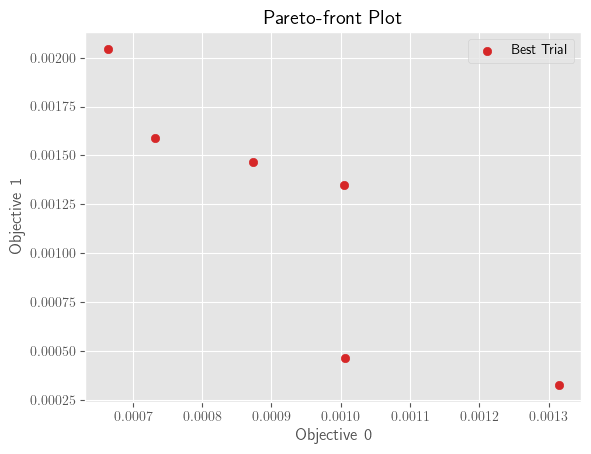

In [90]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [91]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_one_step/trials.joblib']

#### This is the analysis part

In [92]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [93]:
trials_file = save_dir / "trials.joblib"

In [94]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-07-04 18:51:13,113] A new study created in memory with name: no-name-0c412bdc-80e1-4aa9-b981-40725b9f12b8


Assuming minimization for all objectives.


In [95]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [96]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 75
Trial values: peak_distance 1.589e-03 fwhm 7.324e-04
Trial dw:
{'h_sigma': 0.0008760347980272993, 'h_fwhm': 0.00058593750000005, 'h_centroid': 5.8842502530722605e-05, 'h_peak': 7.324218750000104e-05, 'v_sigma': 0.0010136879883969603, 'v_fwhm': 0.00043945312500003747, 'v_centroid': -0.0021194171201777147, 'v_peak': 0.0015869140625, 'integral_intensity': 8335.220988125711, 'peak_intensity': 38.25646380273663, 'gaussian_fit': {}}
Actual fwhm 0.0007324218750000625


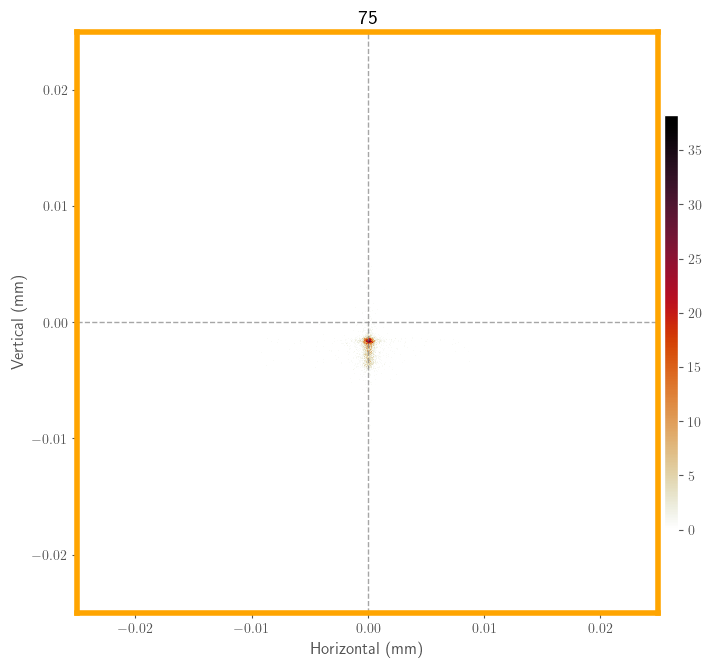

Trial number 79
Trial values: peak_distance 2.045e-03 fwhm 6.641e-04
Trial dw:
{'h_sigma': 0.0008661193978556026, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0018075581741417988, 'h_peak': 0.001879882812499999, 'v_sigma': 0.0009806468121039997, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0003177518998347263, 'v_peak': -0.000805664062500001, 'integral_intensity': 8336.182782437752, 'peak_intensity': 35.997979377479815, 'gaussian_fit': {}}
Actual fwhm 0.0006641343021844044


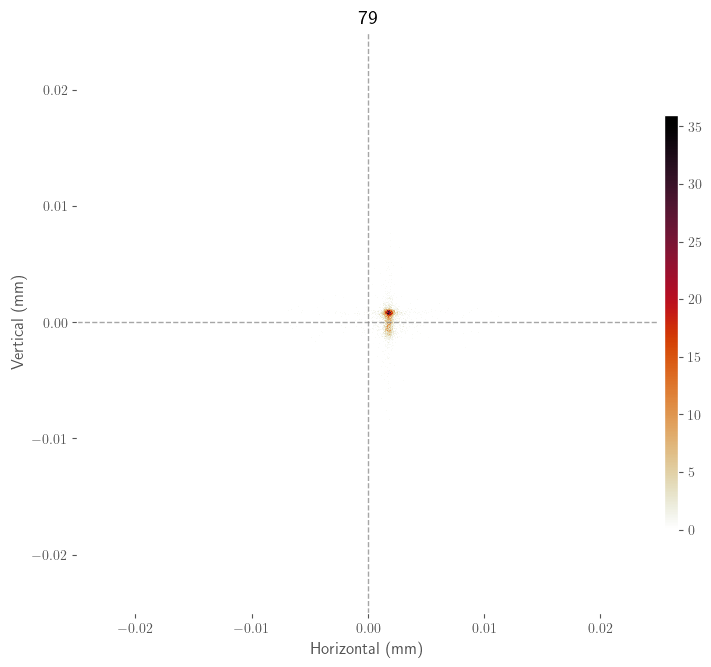

Trial number 88
Trial values: peak_distance 1.347e-03 fwhm 1.005e-03
Trial dw:
{'h_sigma': 0.0009756026468559656, 'h_fwhm': 0.0008789062500000749, 'h_centroid': 0.001172311548127087, 'h_peak': 0.0012451171875000003, 'v_sigma': 0.0008224343135251782, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -0.0005153454462135955, 'v_peak': 0.0005126953125000003, 'integral_intensity': 8340.099240947739, 'peak_intensity': 34.88791421380573, 'gaussian_fit': {}}
Actual fwhm 0.0010054326309558476


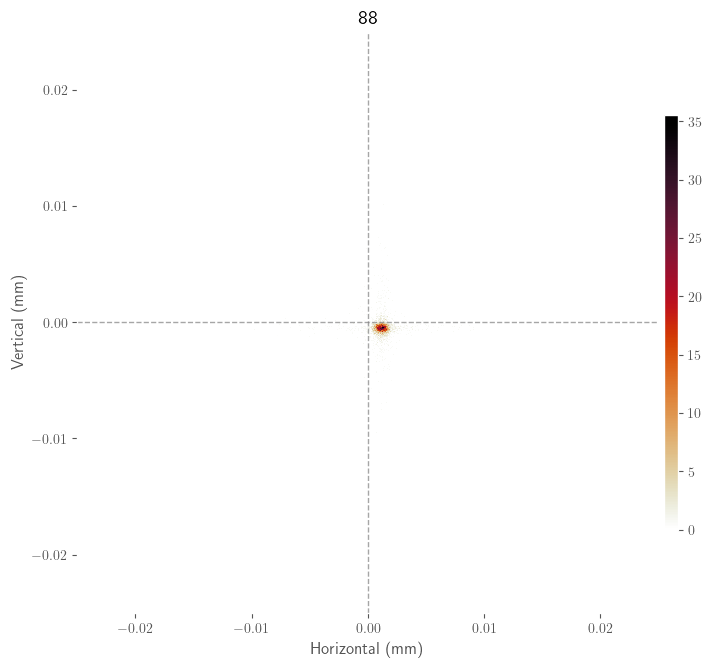

Trial number 114
Trial values: peak_distance 4.645e-04 fwhm 1.007e-03
Trial dw:
{'h_sigma': 0.001023576935770816, 'h_fwhm': 0.0006347656250000541, 'h_centroid': 0.0001271030982094878, 'h_peak': 2.4414062500000347e-05, 'v_sigma': 0.0009134196768585151, 'v_fwhm': 0.0007812500000000666, 'v_centroid': -0.0007331637546285928, 'v_peak': 0.00046386718749999965, 'integral_intensity': 8340.859778399152, 'peak_intensity': 24.646215608071127, 'gaussian_fit': {}}
Actual fwhm 0.0010066175843793975


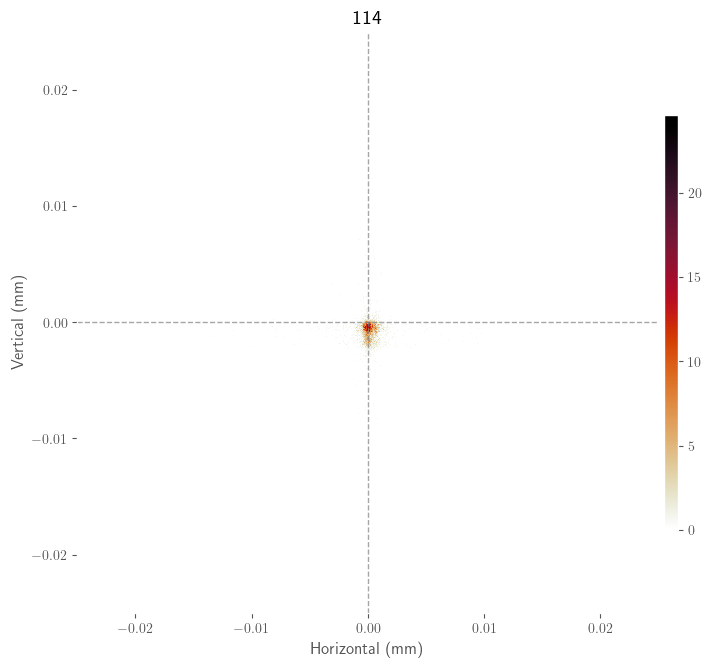

Trial number 117
Trial values: peak_distance 3.257e-04 fwhm 1.315e-03
Trial dw:
{'h_sigma': 0.0010782352246276594, 'h_fwhm': 0.0011230468750000958, 'h_centroid': -5.906605841327078e-05, 'h_peak': -0.00031738281250000104, 'v_sigma': 0.0010674101170579369, 'v_fwhm': 0.0006835937500000583, 'v_centroid': 0.0001979506582826155, 'v_peak': 7.324218750000104e-05, 'integral_intensity': 8342.283860645535, 'peak_intensity': 22.9741705662013, 'gaussian_fit': {}}
Actual fwhm 0.0013147375017419343


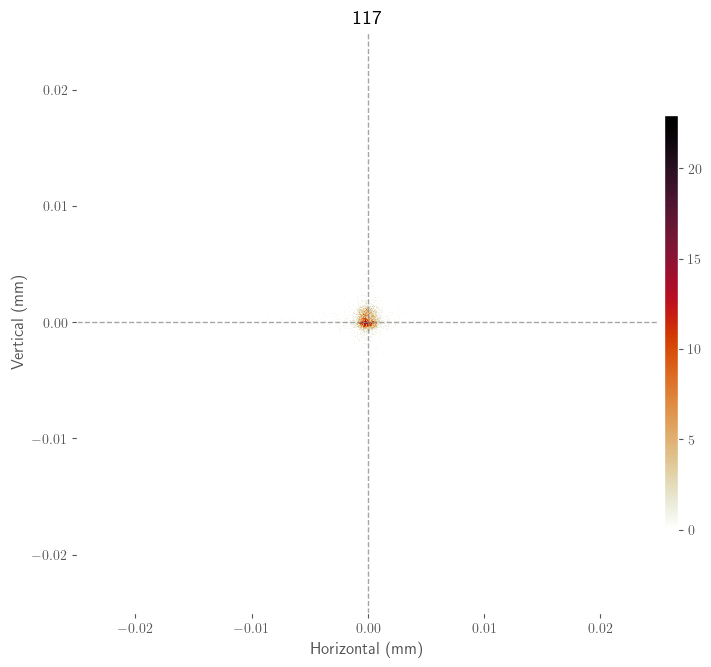

Trial number 122
Trial values: peak_distance 1.465e-03 fwhm 8.735e-04
Trial dw:
{'h_sigma': 0.0009766959948466982, 'h_fwhm': 0.0007812500000000666, 'h_centroid': -0.00021140373498366804, 'h_peak': -0.00026855468750000035, 'v_sigma': 0.001209462387487321, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0008297906723782967, 'v_peak': -0.0014404296874999997, 'integral_intensity': 8337.737539877922, 'peak_intensity': 29.14413503148258, 'gaussian_fit': {}}
Actual fwhm 0.0008734640537109298


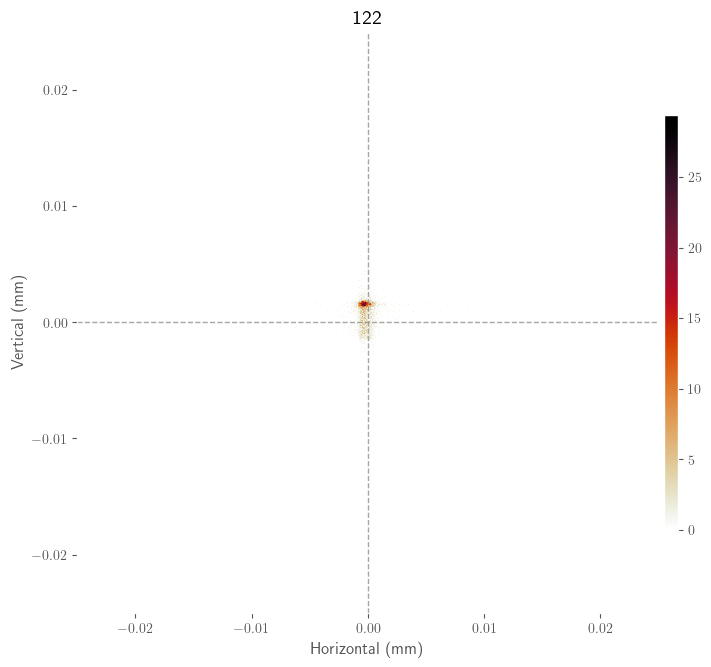

In [97]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()